# Colorado Department of Education - School Rating Predictions

Overview of CDE Performance Ratings: http://www.cde.state.co.us/communications/accountabilityfactsheet2018

## Part I. Get Data
Combines various school and district level data sets as well as performance ratings for the 2015/16, 2016/17 and 2017/18 school years.
    
## Part II. Data Understanding
Descriptive statistics on the data and variables.
    
## Part III. Data Preparation
A few alterations made to the data to prepare for modeling.
    
## Part IV. Modeling
Various modeling techniques used to predict school ratings and segment schools.

## Part V. Evaluation
Compare the average errors of each model's predictions.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
#from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, silhouette_score
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import graphviz 
from sklearn import tree
import scikitplot as skplt

pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

# Part I. Get Data
1. District Data
2. School Data
3. Performance Rating Data

## 1. District Data 
-  Personnel Turnover
-  Teacher Salary
-  District Setting

In [2]:
# Personnel turnover rate for administrators, principals, and overall staff
turnover_2018 = pd.read_excel(r"Data/Personnel Turnover/2017-18 Personnel Turnover Rate by District and Position Categories.xlsx",
                             usecols="B,C,D,K")
turnover_2018 = turnover_2018[:2000]
turnover_2018 = turnover_2018.loc[turnover_2018["Job Classification"].isin(["Adminstrators","Principals","Total Staff"])]
turnover_2018 = turnover_2018.pivot_table(values=["Turnover Rate"], index=["District Code"], columns=["Job Classification"], aggfunc="max")
turnover_2018["School Year"] = "2017/2018"

turnover_2017 = pd.read_excel(r"Data/Personnel Turnover/2016-17 TurnoverDataReport.xlsx",
                             usecols="A,B,C,J")
turnover_2017 = turnover_2017[:1980]
turnover_2017 = turnover_2017.loc[turnover_2017["Job Classification"].isin(["Adminstrators","Principals","Total Staff"])]
turnover_2017 = turnover_2017.pivot_table(values=["Turnover Rate"], index=["District Code"], columns=["Job Classification"], aggfunc="max")
turnover_2017["School Year"] = "2016/2017"

turnover_2016 = pd.read_excel(r"Data/Personnel Turnover/2015-16 4-Revised Turnover Report_3.xlsx",
                             usecols="A,B,C,L")
turnover_2016 = turnover_2016[:1980]
turnover_2016 = turnover_2016.loc[turnover_2016["Job Category"].isin(["Adminstrators","Principals","Total"])]
turnover_2016.loc[turnover_2016["Job Category"] == "Total", "Job Category"] = "Total Staff"
turnover_2016["Organization Code"] = turnover_2016["Organization Code"].astype("str")
turnover_2016 = turnover_2016.pivot_table(values=["Turnover Rate"], index=["Organization Code"], columns=["Job Category"], aggfunc="max")
turnover_2016["School Year"] = "2015/2016"

turnover = pd.concat([turnover_2018, turnover_2017, turnover_2016])
turnover.reset_index(inplace=True)
turnover["DistrictYear"] = turnover["index"] + turnover["School Year"]
turnover.columns = turnover.columns.droplevel()
turnover.columns.values[0] = "District Code"
turnover.columns.values[4] = "School Year"
turnover.columns.values[5] = "DistrictYear"
turnover.head()

Job Classification,District Code,Adminstrators,Principals,Total Staff,School Year,DistrictYear
0,0010,0.050000,0.121212,0.191067,2017/2018,00102017/2018
1,0020,0.388060,0.100917,0.170820,2017/2018,00202017/2018
2,0030,0.260870,0.520000,0.249718,2017/2018,00302017/2018
3,0040,0.222222,0.133333,0.162848,2017/2018,00402017/2018
4,0050,0.111111,0.333333,0.248120,2017/2018,00502017/2018


In [3]:
# Teacher Salaries
salary_2018 = pd.read_excel(r"Data/Teacher Salaries/2017-18 Average Salaries for Teachers.xlsx",
                             skiprows=3, usecols="B,E")
salary_2018 = salary_2018[:196]
salary_2018["Organization Code"] = salary_2018["Organization Code"].map(lambda x:'{0:04d}'.format(int(x)))
salary_2018["School Year"] = "2017/2018"

salary_2017 = pd.read_excel(r"Data/Teacher Salaries/2016-17 AverageTeacherSalary.xlsx",
                             skiprows=3, usecols="C,F")
salary_2017 = salary_2017[:203]
salary_2017["Organization Code"] = salary_2017["Organization Code"].map(lambda x:'{0:04d}'.format(int(x)))
salary_2017["School Year"] = "2016/2017"

salary_2016 = pd.read_excel(r"Data/Teacher Salaries/2015-16 1-Average Salaries for Teachers.xlsx",
                             skiprows=3, usecols="C,F")
salary_2016 = salary_2016[:196]
salary_2016["School Year"] = "2015/2016"

salary = pd.concat([salary_2018, salary_2017, salary_2016])
salary.rename(columns={"Average Salary": "Average Salary_Teacher"}, inplace=True)
salary["DistrictYear"] = salary["Organization Code"] + salary["School Year"]
salary.head()

,Organization Code,Average Salary_Teacher,School Year,DistrictYear
0,0010,56410.389454,2017/2018,00102017/2018
1,0020,59511.365852,2017/2018,00202017/2018
2,0030,57394.320035,2017/2018,00302017/2018
3,0040,49487.840558,2017/2018,00402017/2018
4,0050,39147.780053,2017/2018,00502017/2018


In [4]:
# District Setting
setting_2018 = pd.read_excel(r"Data/DistrictSetting/2017-18_Membership_DistrictSetting.xlsx",
                             skiprows=2, usecols="A,B,D")
setting_2018 = setting_2018[:193]
setting_2018 = setting_2018.loc[setting_2018["County Code"] != "TOTAL"]
setting_2018.drop(["County Code"], axis=1, inplace=True)
setting_2018["School Year"] = "2017/2018"

setting_2017 = pd.read_excel(r"Data/DistrictSetting/2016-17_PupilMembershipbyDistrictSetting.xlsx",
                             skiprows=2, usecols="A,B,D")
setting_2017 = setting_2017[:193]
setting_2017 = setting_2017.loc[setting_2017["County Code"] != "TOTAL"]
setting_2017.drop(["County Code"], axis=1, inplace=True)
setting_2017["School Year"] = "2016/2017"

setting_2016 = pd.read_excel(r"Data/DistrictSetting/2015_16_PupilMembershipbyDistrictSetting.xlsx",
                             skiprows=2, usecols="A,B,D")
setting_2016 = setting_2016[:193]
setting_2016 = setting_2016.loc[setting_2016["County Code"] != "TOTAL"]
setting_2016.drop(["County Code"], axis=1, inplace=True)
setting_2016["School Year"] = "2015/2016"

setting = pd.concat([setting_2018, setting_2017, setting_2016])
setting.rename(columns={"District Code": "Organization Code"}, inplace=True)
setting["DistrictYear"] = setting["Organization Code"] + setting["School Year"]
setting.head()

,District Setting,Organization Code,School Year,DistrictYear
0,Denver Metro,0010,2017/2018,00102017/2018
1,Denver Metro,0020,2017/2018,00202017/2018
2,Denver Metro,0030,2017/2018,00302017/2018
3,Denver Metro,0040,2017/2018,00402017/2018
4,Denver Metro,0070,2017/2018,00702017/2018


## 2. School Data
- Truancy Rates
- Student Demographics
- Free & Reduced Lunch

In [5]:
# Truancy Rates
truancy_2018 = pd.read_excel(r"Data/Truancy/Attendance and Truancy Rates by School 2017-18.xlsx", skiprows=15, usecols="D,F,O")
truancy_2018 = truancy_2018[:1880]
truancy_2018["District Code"] = truancy_2018["District Code"].map(lambda x:'{0:04d}'.format(int(x)))
truancy_2018["School Code"] = truancy_2018["School Code"].map(lambda x:'{0:04d}'.format(int(x)))
truancy_2018["School Year"] = "2017/2018"
truancy_2018.rename(columns={"Truancy Rate** ": "Truancy Rate"}, inplace=True)

truancy_2017 = pd.read_excel(r"Data/Truancy/Attendance 2016-17.xlsx", skiprows=12, usecols="D,F,O")
truancy_2017 = truancy_2017[:1864]
truancy_2017["District Code"] = truancy_2017["District Code"].map(lambda x:'{0:04d}'.format(int(x)))
truancy_2017["School Code"] = truancy_2017["School Code"].map(lambda x:'{0:04d}'.format(int(x)))
truancy_2017["School Year"] = "2016/2017"
truancy_2017.rename(columns={"Truancy Rate** ": "Truancy Rate"}, inplace=True)

truancy_2016 = pd.read_excel(r"Data/Truancy/2015-2016 Attendance Data Report.xlsx", skiprows=15, usecols="D,F,O")
truancy_2016["District Code"] = truancy_2016["District Code"].map(lambda x:'{0:04d}'.format(int(x)))
truancy_2016["School Code"] = truancy_2016["School Code"].map(lambda x:'{0:04d}'.format(int(x)))
truancy_2016["School Year"] = "2015/2016"
truancy_2016.rename(columns={"Truancy Rate (Total Student Days Unexcused Absent/Total days Possible)": "Truancy Rate"}, inplace=True)

truancy = pd.concat([truancy_2018, truancy_2017, truancy_2016])
truancy["SchoolCodeYear"] = truancy["School Code"] + truancy["School Year"]
truancy.head()

,District Code,School Code,Truancy Rate,School Year,SchoolCodeYear
0,0010,0187,0.051256,2017/2018,01872017/2018
1,0010,0212,0.077247,2017/2018,02122017/2018
2,0010,0263,0.087869,2017/2018,02632017/2018
3,0010,0309,0.088270,2017/2018,03092017/2018
4,0010,0501,0.037237,2017/2018,05012017/2018


In [6]:
# Student Demographics
demo_2018 = pd.read_excel(r"Data/Student Demographics/2017-18-Membership-Race-Gender-byGradeSchool.xlsx", skiprows=2)
demo_2018 = demo_2018.loc[demo_2018["Grade Level"] == "ALL GRADE LEVELS"]
demo_2018 = demo_2018.loc[(demo_2018["School Code"] != "0000") & (demo_2018["School Code"] != "No school")]
demo_2018.drop(["Grade Level"], axis=1, inplace=True)
demo_2018["Org. Code"] = demo_2018["Org. Code"].map(lambda x:'{0:04d}'.format(int(x)))
demo_2018["School Year"] = "2017/2018"

demo_2017 = pd.read_excel(r"Data/Student Demographics/2016-17_sch_membershipbysch_race_ethnicity_gender_grade.xlsx", skiprows=2)
demo_2017 = demo_2017.loc[demo_2017["Grade Level"] == "ALL GRADES TOTAL"]
demo_2017 = demo_2017.loc[(demo_2017["School Code"] != "0000") & (demo_2017["School Code"] != "No school")]
demo_2017.drop(["Grade Level"], axis=1, inplace=True)
demo_2017["Org. Code"] = demo_2017["Org. Code"].map(lambda x:'{0:04d}'.format(int(x)))
demo_2017["School Year"] = "2016/2017"

demo_2016 = pd.read_excel(r"Data/Student Demographics/2015_16_sch_membershipbysch_race_ethnicity_gender_grade.xlsx", skiprows=2)
demo_2016 = demo_2016.loc[(demo_2016["Grade Level"].isnull()) & (demo_2016["School Code"].notnull())]
demo_2016 = demo_2016.loc[(demo_2016["School Code"] != "0000") & (demo_2016["School Code"] != "No school")]
demo_2016.drop(["Grade Level"], axis=1, inplace=True)
demo_2016["Org. Code"] = demo_2016["Org. Code"].map(lambda x:'{0:04d}'.format(int(x)))
demo_2016["School Year"] = "2015/2016"

demo = pd.concat([demo_2018, demo_2017, demo_2016])
demo["SchoolCodeYear"] = demo["School Code"].astype("str") + demo["School Year"]
demo.head()

,Org. Code,Organization Name,School Code,School Name,American Indian or Alaskan Native Female,American Indian or Alaskan Native Male,Asian Female,Asian male,Black or African American Female,Black or African American Male,Hispanic or Latino Female,Hispanic or Latino Male,White Female,White Male,Native Hawaiian or Other Pacific Islander Female,Native Hawaiian or Other Pacific Islander Male,Two or More Races Female,Two or More Races Male,PK-12 Total,School Year,SchoolCodeYear
9,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,6,5,5,1,12,5,249,235,79,66,0,1,7,6,677.0,2017/2018,01872017/2018
14,0010,MAPLETON 1,0212,MAPLETON EARLY COLLEGE HIGH SCHOOL,1,3,1,5,2,1,92,86,28,20,0,1,2,7,249.0,2017/2018,02122017/2018
19,0010,MAPLETON 1,0263,GLOBAL LEADERSHIP ACADEMY,0,0,1,2,2,0,101,107,5,7,0,0,1,0,226.0,2017/2018,02632017/2018
24,0010,MAPLETON 1,0309,ACADEMY HIGH SCHOOL,3,3,3,4,4,10,163,193,14,37,1,0,6,7,448.0,2017/2018,03092017/2018
35,0010,MAPLETON 1,0501,MONTEREY COMMUNITY SCHOOL,0,0,7,3,8,0,216,180,30,33,0,0,1,5,483.0,2017/2018,05012017/2018


In [7]:
# Free and Reduced Lunch Eligibility
lunch_2018 = pd.read_excel(r"Data/Free and Reduced Lunch/2017-18_K12_FRL_bySchool.xlsx", skiprows=2)
lunch_2018 = lunch_2018[:1845]
lunch_2018 = lunch_2018.loc[(lunch_2018["SCHOOL CODE"] != 0000) & (lunch_2018["SCHOOL CODE"] != 9999)]
lunch_2018.drop(["COUNTY CODE", "COUNTY NAME", "% FRL RANGE", "NOT ELIGIBLE", "DISTRICT NAME\t", "SCHOOL NAME", "FREE LUNCH", "REDUCED LUNCH", "% FREE","% REDUCED"], axis=1, inplace=True)
lunch_2018["School Year"] = "2017/2018"

lunch_2017 = pd.read_excel(r"Data/Free and Reduced Lunch/2016-17_K-12_PupilMembership_bySchool_FRL.xlsx", skiprows=2)
lunch_2017 = lunch_2017[:1829]
lunch_2017 = lunch_2017.loc[(lunch_2017["SCHOOL CODE"] != 0000) & (lunch_2017["SCHOOL CODE"] != 9999)]
lunch_2017.drop(["COUNTY CODE", "COUNTY NAME", "DISTRICT NAME\t", "SCHOOL NAME", "% FRL Range"], axis=1, inplace=True)
lunch_2017["School Year"] = "2016/2017"

lunch_2016 = pd.read_excel(r"Data/Free and Reduced Lunch/2015_16_K_12_FreeReducedLunchEligibilitybyDistrictandSchool.xlsx", skiprows=2)
lunch_2016 = lunch_2016[:1860]
lunch_2016 = lunch_2016.loc[(lunch_2016["SCHOOL CODE"] != 0000) & (lunch_2016["SCHOOL CODE"] != 9999)]
lunch_2016.drop(["COUNTY CODE", "COUNTY NAME", "DISTRICT NAME\t", "SCHOOL NAME", "FREE LUNCH", "REDUCED LUNCH", "% FREE","% REDUCED", "NOT ELIGIBLE"], axis=1, inplace=True)
lunch_2016["School Year"] = "2015/2016"
lunch_2016.rename(columns={"FREE AND REDUCED": "FREE AND REDUCED COUNT"}, inplace=True)

lunch = pd.concat([lunch_2018, lunch_2017, lunch_2016])
lunch["SCHOOL CODE"] = lunch["SCHOOL CODE"].map(lambda x:'{0:04d}'.format(int(x)))
lunch["SchoolCodeYear"] = lunch["SCHOOL CODE"] + lunch["School Year"]
lunch.head()

,DISTRICT CODE,SCHOOL CODE,K-12 COUNT,FREE AND REDUCED COUNT,% FREE AND REDUCED,School Year,SchoolCodeYear
1,0010,0187,677,473.0,0.699,2017/2018,01872017/2018
2,0010,0212,249,166.0,0.667,2017/2018,02122017/2018
3,0010,0263,226,189.0,0.836,2017/2018,02632017/2018
4,0010,0309,448,295.0,0.658,2017/2018,03092017/2018
5,0010,0501,422,347.0,0.822,2017/2018,05012017/2018


### Merge District & School Data

In [8]:
# Merge District data
districtdata = salary.merge(turnover, how="outer", left_on="DistrictYear", right_on="DistrictYear")
districtdata["District Code_Final"] = districtdata["District Code"].fillna(districtdata["Organization Code"])
districtdata["School Year_Final"] = districtdata["School Year_x"].fillna(districtdata["School Year_y"])
districtdata.drop(["Organization Code","District Code","School Year_x","School Year_y"], axis=1, inplace=True)
districtdata.rename(columns={"Adminstrators":"Turnover_Adminstrators", "Principals":"Turnover_Principals", "Total Staff":"Turnover_Total Staff","District Code_Final":"District Code","School Year_Final":"School Year", "DistrictYear":"DistrictCodeYear"}, inplace=True)
districtdata = districtdata[["District Code","School Year","DistrictCodeYear","Average Salary_Teacher","Turnover_Adminstrators","Turnover_Principals","Turnover_Total Staff"]]
districtdata = districtdata.merge(setting, how="outer", left_on="DistrictCodeYear", right_on="DistrictYear")
districtdata.drop(["School Year_y","DistrictYear","Organization Code"], axis=1,inplace=True)
districtdata = districtdata.loc[districtdata["District Setting"] != "Detention Centers"]
districtdata.rename(columns={"School Year_x": "School Year"}, inplace=True)
districtdata.head()

,District Code,School Year,DistrictCodeYear,Average Salary_Teacher,Turnover_Adminstrators,Turnover_Principals,Turnover_Total Staff,District Setting
0,0010,2017/2018,00102017/2018,56410.389454,0.050000,0.121212,0.191067,Denver Metro
1,0020,2017/2018,00202017/2018,59511.365852,0.388060,0.100917,0.170820,Denver Metro
2,0030,2017/2018,00302017/2018,57394.320035,0.260870,0.520000,0.249718,Denver Metro
3,0040,2017/2018,00402017/2018,49487.840558,0.222222,0.133333,0.162848,Denver Metro
4,0050,2017/2018,00502017/2018,39147.780053,0.111111,0.333333,0.248120,Outlying Town


In [9]:
# Merge School data
schooldata = truancy.merge(demo, how="outer", left_on="SchoolCodeYear", right_on="SchoolCodeYear").merge(lunch, how="outer", left_on="SchoolCodeYear", right_on="SchoolCodeYear")
schooldata["School Code_FINAL"] = schooldata["School Code_x"].fillna(schooldata["School Code_y"]).fillna(schooldata["SCHOOL CODE"])
schooldata["District Code_FINAL"] = schooldata["District Code"].fillna(schooldata["Org. Code"]).fillna(schooldata["DISTRICT CODE"])
schooldata["School Year_FINAL"] = schooldata["School Year_x"].fillna(schooldata["School Year_y"]).fillna(schooldata["School Year"])
schooldata.drop(["SCHOOL CODE", "School Code_x", "School Code_y", "Org. Code", "DISTRICT CODE", "District Code", "School Year_y", "School Year"], axis=1, inplace=True)
schooldata.rename(columns={"School Code_FINAL":  "School Code", "School Year_FINAL":  "School Year", "Organization Name":"District Name", "District Code_FINAL": "District Code"}, inplace=True)
schooldata["DistrictCodeYear"] = schooldata["District Code"] + schooldata["School Year"]
schooldata = schooldata[["District Code", "District Name", "School Code", "School Name", "School Year", "DistrictCodeYear", "SchoolCodeYear", "Truancy Rate", "American Indian or Alaskan Native Female", "American Indian or Alaskan Native Male", "Asian Female", "Asian male", "Black or African American Female", "Black or African American Male", "Hispanic or Latino Female", "Hispanic or Latino Male", "White Female", "White Male", "Native Hawaiian or Other Pacific Islander Female", "Native Hawaiian or Other Pacific Islander Male", "Two or More Races Female", "Two or More Races Male", "PK-12 Total", "K-12 COUNT", "FREE AND REDUCED COUNT", "% FREE AND REDUCED"]]
schooldata.head()

,District Code,District Name,School Code,School Name,School Year,DistrictCodeYear,SchoolCodeYear,Truancy Rate,American Indian or Alaskan Native Female,American Indian or Alaskan Native Male,Asian Female,Asian male,Black or African American Female,Black or African American Male,Hispanic or Latino Female,Hispanic or Latino Male,White Female,White Male,Native Hawaiian or Other Pacific Islander Female,Native Hawaiian or Other Pacific Islander Male,Two or More Races Female,Two or More Races Male,PK-12 Total,K-12 COUNT,FREE AND REDUCED COUNT,% FREE AND REDUCED
0,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,2017/2018,00102017/2018,01872017/2018,0.051256,6,5,5,1,12,5,249,235,79,66,0,1,7,6,677.0,677.0,473.0,0.699
1,0010,MAPLETON 1,0212,MAPLETON EARLY COLLEGE HIGH SCHOOL,2017/2018,00102017/2018,02122017/2018,0.077247,1,3,1,5,2,1,92,86,28,20,0,1,2,7,249.0,249.0,166.0,0.667
2,0010,MAPLETON 1,0263,GLOBAL LEADERSHIP ACADEMY,2017/2018,00102017/2018,02632017/2018,0.087869,0,0,1,2,2,0,101,107,5,7,0,0,1,0,226.0,226.0,189.0,0.836
3,0010,MAPLETON 1,0309,ACADEMY HIGH SCHOOL,2017/2018,00102017/2018,03092017/2018,0.088270,3,3,3,4,4,10,163,193,14,37,1,0,6,7,448.0,448.0,295.0,0.658
4,0010,MAPLETON 1,0501,MONTEREY COMMUNITY SCHOOL,2017/2018,00102017/2018,05012017/2018,0.037237,0,0,7,3,8,0,216,180,30,33,0,0,1,5,483.0,422.0,347.0,0.822


In [10]:
# Merge School and District Data
data = schooldata.merge(districtdata, how="left", left_on="DistrictCodeYear", right_on="DistrictCodeYear")
data.sort_values(["District Code_x", "School Code", "School Year_x"], ascending=[True, True, True], inplace=True)
data.drop(["District Code_y", "School Year_y"], axis=1, inplace=True)
data.rename(columns={"District Code_x":"District Code", "School Year_x":"School Year"}, inplace=True)
data.head()

,District Code,District Name,School Code,School Name,School Year,DistrictCodeYear,SchoolCodeYear,Truancy Rate,American Indian or Alaskan Native Female,American Indian or Alaskan Native Male,Asian Female,Asian male,Black or African American Female,Black or African American Male,Hispanic or Latino Female,Hispanic or Latino Male,White Female,White Male,Native Hawaiian or Other Pacific Islander Female,Native Hawaiian or Other Pacific Islander Male,Two or More Races Female,Two or More Races Male,PK-12 Total,K-12 COUNT,FREE AND REDUCED COUNT,% FREE AND REDUCED,Average Salary_Teacher,Turnover_Adminstrators,Turnover_Principals,Turnover_Total Staff,District Setting
3744,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,2015/2016,00102015/2016,01872015/2016,0.050442,2,3,2,3,9,7,214,231,82,83,0,1,8,5,650.0,650.0,416.0,0.640000,49527.569825,0.285714,0.125000,0.173055,Denver Metro
1880,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,2016/2017,00102016/2017,01872016/2017,0.050499,6,1,4,1,8,5,215,238,73,72,0,1,8,6,638.0,638.0,404.0,0.633000,52969.030173,0.142857,0.235294,0.229285,Denver Metro
0,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,2017/2018,00102017/2018,01872017/2018,0.051256,6,5,5,1,12,5,249,235,79,66,0,1,7,6,677.0,677.0,473.0,0.699000,56410.389454,0.050000,0.121212,0.191067,Denver Metro
3745,0010,MAPLETON 1,0212,MAPLETON EARLY COLLEGE HIGH SCHOOL,2015/2016,00102015/2016,02122015/2016,0.056794,1,1,1,1,2,3,105,87,28,34,0,0,2,8,273.0,273.0,179.0,0.655678,49527.569825,0.285714,0.125000,0.173055,Denver Metro
1881,0010,MAPLETON 1,0212,MAPLETON EARLY COLLEGE HIGH SCHOOL,2016/2017,00102016/2017,02122016/2017,0.068902,1,1,1,3,3,1,89,82,29,26,0,1,1,7,245.0,245.0,148.0,0.604000,52969.030173,0.142857,0.235294,0.229285,Denver Metro


In [11]:
data.shape

(5616, 31)

## 3. Ratings Data
-  2017/18
-  2016/17
-  2015/16

### 2017/18 Ratings

In [12]:
ratings_2018 = pd.read_excel(r"Data/RATINGS/2017-18 SPF Prelim Ratings with Historical_v2.xlsx", sheet_name="Data", usecols="A,C,E,G,I,J,Z,AA")
ratings_2018.rename(columns={"District Number":"DIST_NUMBER", "School Number":"SCH_NUMBER","Level (E=elementary, m=middle, h=high)":"EMH_TYPE", "Charter":"CHARTER_YN", "Online":"ONLINE_YN", "Calculated Preliminary 2018 Rating":"RATING_PRELIMINARY","Total_% of Points Earned 2018":"PCT_PTS_EARN_WEIGHTED"}, inplace=True)
ratings_2018["DIST_NUMBER"] = ratings_2018["DIST_NUMBER"].map(lambda x:'{0:04d}'.format(int(x)))
ratings_2018["SCH_NUMBER"] = ratings_2018["SCH_NUMBER"].map(lambda x:'{0:04d}'.format(int(x)))
ratings_2018["School Year"] = "2017/2018"
ratings_2018["PCT_PTS_EARN_WEIGHTED"] = ratings_2018["PCT_PTS_EARN_WEIGHTED"]/100
ratings_2018["CLOSED_SCHOOL_YN"] = "N"
ratings_2018 = ratings_2018.loc[ratings_2018["AEC"] != "Y"]
ratings_2018.drop(["AEC"], axis=1, inplace=True)
ratings_2018.head()

,DIST_NUMBER,SCH_NUMBER,EMH_TYPE,CHARTER_YN,ONLINE_YN,RATING_PRELIMINARY,PCT_PTS_EARN_WEIGHTED,School Year,CLOSED_SCHOOL_YN
0,0880,0010,H,N,N,Priority Improvement Plan: Low Participation,0.418,2017/2018,N
1,0900,0011,EM,Y,N,Performance Plan: Low Participation,0.913,2017/2018,N
2,0900,0012,E,N,N,Performance Plan: Low Participation,0.706,2017/2018,N
3,0020,0014,E,N,N,Performance Plan: Meets 95% Participation,0.671,2017/2018,N
4,8001,0015,EMH,Y,N,Performance Plan: Low Participation,0.700,2017/2018,N


In [13]:
ratings_2018.shape

(1769, 9)

### 2016/17 Ratings

In [14]:
ratings_2017 = pd.read_excel(r"Data/Ratings/2016-17 DPF_SPF_PUBLIC_DATA.xlsx", sheet_name="INDICATOR_TTLS_ALL_LEVELS")
ratings_2017.head()

,REPORT_YEAR,REPORT,REPORT_LEVEL,DATA_SET,DIST_NUMBER,DIST_NAME,SCH_NUMBER,SCH_NAME,EMH_TYPE,K12_ENROLLMENT,K12_PCT_FRL,K12_PCT_MINORITY,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,CLOSED_SCHOOL_YN,NEW_SCHOOL_YN,ALTERNATIVE_ED_CAMPUS_YN,ONLINE_YN,CHARTER_YN,REPORT_TYPE,APPROVED_REQ_TO_RECONSIDER,EMH_CODE,INDICATOR,SUBINDICATOR,SUBCATEGORY,RATING_PRELIMINARY,RATING_FINAL,PTS_EARN,PTS_ELIG,PCT_PTS_EARN,PTS_EARN_WEIGHTED,PTS_ELIG_WEIGHTED,PCT_PTS_EARN_WEIGHTED
0,2017,PERFORMANCE FRAMEWORK,INDICATOR TOTALS: ALL LEVELS,DIST,10,MAPLETON 1,ALL,ALL,EMH,8365.0,0.587,0.699,0.362,0.122,N,N,N,N,N,SINGLE-YEAR,N,ALL,ACH,TOTAL,TOTAL,Approaching,Approaching,97.00,216.0,0.449,13.5,30.0,0.449
1,2017,PERFORMANCE FRAMEWORK,INDICATOR TOTALS: ALL LEVELS,DIST,10,MAPLETON 1,ALL,ALL,EMH,8365.0,0.587,0.699,0.362,0.122,N,N,N,N,N,SINGLE-YEAR,N,ALL,GRO,TOTAL,TOTAL,Approaching,Approaching,83.25,144.0,0.578,23.1,40.0,0.578
2,2017,PERFORMANCE FRAMEWORK,INDICATOR TOTALS: ALL LEVELS,DIST,10,MAPLETON 1,ALL,ALL,EMH,8365.0,0.587,0.699,0.362,0.122,N,N,N,N,N,SINGLE-YEAR,N,ALL,PWR,TOTAL,TOTAL,Approaching,Approaching,7.25,18.0,0.403,12.1,30.0,0.403
3,2017,PERFORMANCE FRAMEWORK,INDICATOR TOTALS: ALL LEVELS,DIST,10,MAPLETON 1,ALL,ALL,EMH,8365.0,0.587,0.699,0.362,0.122,N,N,N,N,N,SINGLE-YEAR,N,ALL,PART,TOTAL,TOTAL,Meets 95% Participation,Meets 95% Participation,3.00,3.0,NaN,NaN,NaN,NaN
4,2017,PERFORMANCE FRAMEWORK,INDICATOR TOTALS: ALL LEVELS,DIST,10,MAPLETON 1,ALL,ALL,EMH,8365.0,0.587,0.699,0.362,0.122,N,N,N,N,N,SINGLE-YEAR,N,ALL,CLOCK,TOTAL,TOTAL,-,-,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
ratings_2017 = ratings_2017.loc[ratings_2017["DATA_SET"] == "SCH"]
ratings_2017 = ratings_2017.loc[ratings_2017["ALTERNATIVE_ED_CAMPUS_YN"] == "N"]
ratings_2017 = ratings_2017.loc[ratings_2017["REPORT_TYPE"] == "SINGLE-YEAR"]
ratings_2017.drop(["REPORT_YEAR","REPORT","REPORT_LEVEL", "REPORT_TYPE", "DATA_SET","DIST_NAME","SCH_NAME","ALTERNATIVE_ED_CAMPUS_YN","APPROVED_REQ_TO_RECONSIDER","EMH_CODE","SUBINDICATOR","SUBCATEGORY","RATING_FINAL","PCT_PTS_EARN"], axis=1, inplace=True)
ratings_2017 = ratings_2017.loc[~ratings_2017["INDICATOR"].isin(["CLOCK","AWARDS"])]
ratings_2017.loc[ratings_2017["INDICATOR"] == "PART", "PTS_EARN_WEIGHTED"] = ratings_2017["PTS_EARN"]
ratings_2017.loc[ratings_2017["INDICATOR"] == "PART", "PTS_ELIG_WEIGHTED"] = ratings_2017["PTS_ELIG"]
ratings_2017["PCT_PTS_EARN_WEIGHTED"] = round(ratings_2017["PTS_EARN_WEIGHTED"] / ratings_2017["PTS_ELIG_WEIGHTED"], 3)
ratings_2017.head()

,DIST_NUMBER,SCH_NUMBER,EMH_TYPE,K12_ENROLLMENT,K12_PCT_FRL,K12_PCT_MINORITY,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,CLOSED_SCHOOL_YN,NEW_SCHOOL_YN,ONLINE_YN,CHARTER_YN,INDICATOR,RATING_PRELIMINARY,PTS_EARN,PTS_ELIG,PTS_EARN_WEIGHTED,PTS_ELIG_WEIGHTED,PCT_PTS_EARN_WEIGHTED
1479,10,0187,MH,638.0,0.633,0.773,0.359,0.114,N,N,N,N,ACH,Does Not Meet,50.00,136.0,11.0,30.0,0.367
1480,10,0187,MH,638.0,0.633,0.773,0.359,0.114,N,N,N,N,GRO,Approaching,55.75,90.0,24.8,40.0,0.620
1481,10,0187,MH,638.0,0.633,0.773,0.359,0.114,N,N,N,N,PWR,Approaching,10.75,18.0,17.9,30.0,0.597
1482,10,0187,MH,638.0,0.633,0.773,0.359,0.114,N,N,N,N,PART,Meets 95% Participation,3.00,3.0,3.0,3.0,1.000
1485,10,0212,H,245.0,0.604,0.776,0.400,0.151,N,N,N,N,ACH,Does Not Meet,23.25,66.0,10.6,30.0,0.353


In [16]:
ratings_2017_data = ratings_2017.pivot_table(values=["PCT_PTS_EARN_WEIGHTED"],index="SCH_NUMBER",columns="INDICATOR")
ratings_2017_data.columns = ratings_2017_data.columns.droplevel()
ratings_2017_data.head()

INDICATOR,ACH,GRO,PART,PWR
SCH_NUMBER,,,,
0010,0.287,0.610,1.0,0.513
0011,0.912,0.552,1.0,NaN
0012,0.640,0.718,1.0,NaN
0014,0.538,0.750,1.0,NaN
0015,0.677,0.535,1.0,0.767


In [17]:
ratings_2017_demo = ratings_2017.groupby(["SCH_NUMBER"]).max()
ratings_2017_demo.drop(["INDICATOR","RATING_PRELIMINARY","PTS_EARN","PTS_ELIG","PTS_EARN_WEIGHTED","PTS_ELIG_WEIGHTED","PCT_PTS_EARN_WEIGHTED"],axis=1,inplace=True)
ratings_2017_demo.head()

,DIST_NUMBER,EMH_TYPE,K12_ENROLLMENT,K12_PCT_FRL,K12_PCT_MINORITY,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,CLOSED_SCHOOL_YN,NEW_SCHOOL_YN,ONLINE_YN,CHARTER_YN
SCH_NUMBER,,,,,,,,,,,
0010,880,H,1159.0,0.921,0.973,0.742,0.109,N,N,N,N
0011,900,EM,796.0,0.065,0.176,0.015,0.030,N,N,N,Y
0012,900,E,611.0,0.239,0.496,0.214,0.126,N,N,N,N
0014,20,E,489.0,0.372,0.476,0.092,0.104,N,N,N,N
0015,8001,EMH,1830.0,0.216,0.392,0.119,0.061,N,N,N,Y


In [18]:
ratings_2017_data = ratings_2017_demo.merge(ratings_2017_data, how="inner", left_index=True, right_index=True)
ratings_2017_data["DIST_NUMBER"] = ratings_2017_data["DIST_NUMBER"].map(lambda x:'{0:04d}'.format(int(x)))
ratings_2017_data.head()

,DIST_NUMBER,EMH_TYPE,K12_ENROLLMENT,K12_PCT_FRL,K12_PCT_MINORITY,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,CLOSED_SCHOOL_YN,NEW_SCHOOL_YN,ONLINE_YN,CHARTER_YN,ACH,GRO,PART,PWR
SCH_NUMBER,,,,,,,,,,,,,,,
0010,0880,H,1159.0,0.921,0.973,0.742,0.109,N,N,N,N,0.287,0.610,1.0,0.513
0011,0900,EM,796.0,0.065,0.176,0.015,0.030,N,N,N,Y,0.912,0.552,1.0,NaN
0012,0900,E,611.0,0.239,0.496,0.214,0.126,N,N,N,N,0.640,0.718,1.0,NaN
0014,0020,E,489.0,0.372,0.476,0.092,0.104,N,N,N,N,0.538,0.750,1.0,NaN
0015,8001,EMH,1830.0,0.216,0.392,0.119,0.061,N,N,N,Y,0.677,0.535,1.0,0.767


In [19]:
ratings_2017_complete = pd.read_excel(r"Data/Ratings/2016-17 DPF_SPF_PUBLIC_DATA.xlsx", sheet_name="FRAMEWORK_TTLS_ALL_LEVELS")
ratings_2017_complete = ratings_2017_complete.loc[ratings_2017_complete["DATA_SET"] == "SCH"]
ratings_2017_complete = ratings_2017_complete.loc[ratings_2017_complete["ALTERNATIVE_ED_CAMPUS_YN"] == "N"]
ratings_2017_complete = ratings_2017_complete.loc[ratings_2017_complete["REPORT_TYPE"] == "SINGLE-YEAR"]
ratings_2017_complete = ratings_2017_complete[["SCH_NUMBER","RATING_PRELIMINARY","PTS_EARN_WEIGHTED","PTS_ELIG_WEIGHTED","PCT_PTS_EARN_WEIGHTED"]]
ratings_2017_complete.head()

,SCH_NUMBER,RATING_PRELIMINARY,PTS_EARN_WEIGHTED,PTS_ELIG_WEIGHTED,PCT_PTS_EARN_WEIGHTED
185,0187,Performance Plan: Low Participation,53.7,100.0,0.537
186,0212,Performance Plan: Meets 95% Participation,53.1,100.0,0.531
187,0263,Improvement Plan: Meets 95% Participation,45.3,100.0,0.453
188,0309,Improvement Plan: Meets 95% Participation,47.7,100.0,0.477
189,0501,Improvement Plan: Meets 95% Participation,52.1,100.0,0.521


In [20]:
ratings_2017_data = ratings_2017_data.merge(ratings_2017_complete, how="inner", left_index=True, right_on="SCH_NUMBER")
ratings_2017_data["School Year"] = "2016/2017"
ratings_2017_data.head()

,DIST_NUMBER,EMH_TYPE,K12_ENROLLMENT,K12_PCT_FRL,K12_PCT_MINORITY,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,CLOSED_SCHOOL_YN,NEW_SCHOOL_YN,ONLINE_YN,CHARTER_YN,ACH,GRO,PART,PWR,SCH_NUMBER,RATING_PRELIMINARY,PTS_EARN_WEIGHTED,PTS_ELIG_WEIGHTED,PCT_PTS_EARN_WEIGHTED,School Year
665,0880,H,1159.0,0.921,0.973,0.742,0.109,N,N,N,N,0.287,0.610,1.0,0.513,0010,Improvement Plan: Meets 95% Participation,48.4,100.0,0.484,2016/2017
873,0900,EM,796.0,0.065,0.176,0.015,0.030,N,N,N,Y,0.912,0.552,1.0,NaN,0011,Performance Plan: Low Participation,69.6,100.0,0.696,2016/2017
874,0900,E,611.0,0.239,0.496,0.214,0.126,N,N,N,N,0.640,0.718,1.0,NaN,0012,Performance Plan: Low Participation,68.7,100.0,0.687,2016/2017
203,0020,E,489.0,0.372,0.476,0.092,0.104,N,N,N,N,0.538,0.750,1.0,NaN,0014,Performance Plan: Meets 95% Participation,66.5,100.0,0.665,2016/2017
1967,8001,EMH,1830.0,0.216,0.392,0.119,0.061,N,N,N,Y,0.677,0.535,1.0,0.767,0015,Performance Plan: Low Participation,64.7,100.0,0.647,2016/2017


### 2015/16 Ratings

In [21]:
ratings_2016 = pd.read_excel(r"Data/RATINGS/2015-16 DPF_SPF_PUBLIC_DATA_FILE_2016_02_14_2017.xlsx", sheet_name="INDICATOR_TTLS_ALL_LEVELS")
ratings_2016.head()

,REPORT_YEAR,REPORT,REPORT_LEVEL,DATA_SET,DIST_NUMBER,DIST_NAME,SCH_NUMBER,SCH_NAME,EMH_TYPE,K12_ENROLLMENT,K12_PCT_FRL,K12_PCT_MINORITY,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,CLOSED_SCHOOL_YN,NEW_SCHOOL_YN,ALTERNATIVE_ED_CAMPUS_YN,ONLINE_YN,CHARTER_YN,REPORT_TYPE,APPROVED_REQ_TO_RECONSIDER,EMH_CODE,INDICATOR,SUBINDICATOR,SUBCATEGORY,RATING_PRELIMINARY,RATING_FINAL,PTS_EARN,PTS_ELIG,PCT_PTS_EARN,PTS_EARN_WEIGHTED,PTS_ELIG_WEIGHTED,PCT_PTS_EARN_WEIGHTED
0,2016,PERFORMANCE FRAMEWORK,INDICATOR TOTALS: ALL LEVELS,DIST,10,MAPLETON 1,ALL,ALL,EMH,8290,0.628,0.682,0.351,0.107,N,N,N,N,N,STANDARD,N,ALL,ACH,TOTAL,TOTAL,Approaching,Approaching,51.5,108.0,0.477,14.3,30.0,0.477
1,2016,PERFORMANCE FRAMEWORK,INDICATOR TOTALS: ALL LEVELS,DIST,10,MAPLETON 1,ALL,ALL,EMH,8290,0.628,0.682,0.351,0.107,N,N,N,N,N,STANDARD,N,ALL,GRO,TOTAL,TOTAL,Approaching,Approaching,50.5,84.0,0.601,24.0,40.0,0.601
2,2016,PERFORMANCE FRAMEWORK,INDICATOR TOTALS: ALL LEVELS,DIST,10,MAPLETON 1,ALL,ALL,EMH,8290,0.628,0.682,0.351,0.107,N,N,N,N,N,STANDARD,N,ALL,PWR,TOTAL,TOTAL,Approaching,Approaching,7.0,18.0,0.389,11.7,30.0,0.389
3,2016,PERFORMANCE FRAMEWORK,INDICATOR TOTALS: ALL LEVELS,DIST,10,MAPLETON 1,ALL,ALL,EMH,8290,0.628,0.682,0.351,0.107,N,N,N,N,N,STANDARD,N,ALL,PART,TOTAL,TOTAL,Meets 95% Participation,Meets 95% Participation,3.0,4.0,NaN,NaN,NaN,NaN
4,2016,PERFORMANCE FRAMEWORK,INDICATOR TOTALS: ALL LEVELS,DIST,10,MAPLETON 1,ALL,ALL,EMH,8290,0.628,0.682,0.351,0.107,N,N,N,N,N,STANDARD,N,ALL,CLOCK,TOTAL,TOTAL,-,-,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
ratings_2016 = ratings_2016.loc[ratings_2016["DATA_SET"] == "SCH"]
ratings_2016 = ratings_2016.loc[ratings_2016["ALTERNATIVE_ED_CAMPUS_YN"] == "N"]
ratings_2016 = ratings_2016.loc[ratings_2016["REPORT_TYPE"] == "STANDARD"]
ratings_2016.drop(["REPORT_YEAR","REPORT","REPORT_LEVEL", "REPORT_TYPE", "DATA_SET","DIST_NAME","SCH_NAME","ALTERNATIVE_ED_CAMPUS_YN","APPROVED_REQ_TO_RECONSIDER","EMH_CODE","SUBINDICATOR","SUBCATEGORY","RATING_FINAL","PCT_PTS_EARN"], axis=1, inplace=True)
ratings_2016 = ratings_2016.loc[~ratings_2016["INDICATOR"].isin(["CLOCK","AWARDS"])]
ratings_2016.loc[ratings_2016["INDICATOR"] == "PART", "PTS_EARN_WEIGHTED"] = ratings_2016["PTS_EARN"]
ratings_2016.loc[ratings_2016["INDICATOR"] == "PART", "PTS_ELIG_WEIGHTED"] = ratings_2016["PTS_ELIG"]
ratings_2016["PCT_PTS_EARN_WEIGHTED"] = round(ratings_2016["PTS_EARN_WEIGHTED"] / ratings_2016["PTS_ELIG_WEIGHTED"], 3)
ratings_2016.head()

,DIST_NUMBER,SCH_NUMBER,EMH_TYPE,K12_ENROLLMENT,K12_PCT_FRL,K12_PCT_MINORITY,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,CLOSED_SCHOOL_YN,NEW_SCHOOL_YN,ONLINE_YN,CHARTER_YN,INDICATOR,RATING_PRELIMINARY,PTS_EARN,PTS_ELIG,PTS_EARN_WEIGHTED,PTS_ELIG_WEIGHTED,PCT_PTS_EARN_WEIGHTED
1479,10,0187,MH,650,0.643,0.746,0.337,0.118,N,N,N,N,ACH,Does Not Meet,25.75,69.0,11.2,30.0,0.373
1480,10,0187,MH,650,0.643,0.746,0.337,0.118,N,N,N,N,GRO,Meets,34.25,54.0,25.4,40.0,0.635
1481,10,0187,MH,650,0.643,0.746,0.337,0.118,N,N,N,N,PWR,Meets,11.50,18.0,19.2,30.0,0.640
1482,10,0187,MH,650,0.643,0.746,0.337,0.118,N,N,N,N,PART,Meets 95% Participation,4.00,4.0,4.0,4.0,1.000
1485,10,0212,H,273,0.656,0.773,0.403,0.128,N,N,N,N,ACH,Approaching,15.75,33.0,14.3,30.0,0.477


In [23]:
ratings_2016_data = ratings_2016.pivot_table(values=["PCT_PTS_EARN_WEIGHTED"],index="SCH_NUMBER",columns="INDICATOR")
ratings_2016_data.columns = ratings_2016_data.columns.droplevel()
ratings_2016_data.head()

INDICATOR,ACH,GRO,PART,PWR
SCH_NUMBER,,,,
0010,0.327,0.615,0.75,0.417
0011,0.838,0.573,1.00,NaN
0012,0.662,0.598,0.00,NaN
0014,0.470,0.633,1.00,NaN
0015,0.740,0.635,1.00,0.750


In [24]:
ratings_2016_demo = ratings_2016.groupby(["SCH_NUMBER"]).max()
ratings_2016_demo.drop(["INDICATOR","RATING_PRELIMINARY","PTS_EARN","PTS_ELIG","PTS_EARN_WEIGHTED","PTS_ELIG_WEIGHTED","PCT_PTS_EARN_WEIGHTED"],axis=1,inplace=True)
ratings_2016_demo.head()

,DIST_NUMBER,EMH_TYPE,K12_ENROLLMENT,K12_PCT_FRL,K12_PCT_MINORITY,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,CLOSED_SCHOOL_YN,NEW_SCHOOL_YN,ONLINE_YN,CHARTER_YN
SCH_NUMBER,,,,,,,,,,,
0010,880,H,1393,0.932,0.977,0.712,0.110,N,N,N,N
0011,900,EM,728,0.066,0.172,0.015,0.030,N,N,N,Y
0012,900,E,660,0.230,0.442,0.162,0.118,N,N,N,N
0014,20,E,513,0.298,0.460,0.123,0.117,N,N,N,N
0015,8001,EMH,1819,0.179,0.388,0.117,0.057,N,N,N,Y


In [25]:
ratings_2016_data = ratings_2016_demo.merge(ratings_2016_data, how="inner", left_index=True, right_index=True)
ratings_2016_data["DIST_NUMBER"] = ratings_2016_data["DIST_NUMBER"].map(lambda x:'{0:04d}'.format(int(x)))
ratings_2016_data.head()

,DIST_NUMBER,EMH_TYPE,K12_ENROLLMENT,K12_PCT_FRL,K12_PCT_MINORITY,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,CLOSED_SCHOOL_YN,NEW_SCHOOL_YN,ONLINE_YN,CHARTER_YN,ACH,GRO,PART,PWR
SCH_NUMBER,,,,,,,,,,,,,,,
0010,0880,H,1393,0.932,0.977,0.712,0.110,N,N,N,N,0.327,0.615,0.75,0.417
0011,0900,EM,728,0.066,0.172,0.015,0.030,N,N,N,Y,0.838,0.573,1.00,NaN
0012,0900,E,660,0.230,0.442,0.162,0.118,N,N,N,N,0.662,0.598,0.00,NaN
0014,0020,E,513,0.298,0.460,0.123,0.117,N,N,N,N,0.470,0.633,1.00,NaN
0015,8001,EMH,1819,0.179,0.388,0.117,0.057,N,N,N,Y,0.740,0.635,1.00,0.750


In [26]:
ratings_2016_complete = pd.read_excel(r"Data/RATINGS/2015-16 DPF_SPF_PUBLIC_DATA_FILE_2016_02_14_2017.xlsx", sheet_name="FRAMEWORK_TTLS_ALL_LEVELS")
ratings_2016_complete = ratings_2016_complete.loc[ratings_2016_complete["DATA_SET"] == "SCH"]
ratings_2016_complete = ratings_2016_complete.loc[ratings_2016_complete["ALTERNATIVE_ED_CAMPUS_YN"] == "N"]
ratings_2016_complete = ratings_2016_complete.loc[ratings_2016_complete["REPORT_TYPE"] == "STANDARD"]
ratings_2016_complete = ratings_2016_complete[["SCH_NUMBER","RATING_PRELIMINARY","PTS_EARN_WEIGHTED","PTS_ELIG_WEIGHTED","PCT_PTS_EARN_WEIGHTED"]]
ratings_2016_complete.head()

,SCH_NUMBER,RATING_PRELIMINARY,PTS_EARN_WEIGHTED,PTS_ELIG_WEIGHTED,PCT_PTS_EARN_WEIGHTED
185,0187,Performance Plan: Low Participation^,55.8,100.0,0.558
186,0212,Performance Plan,62.6,100.0,0.626
187,0263,Performance Plan,53.3,100.0,0.533
188,0309,Improvement Plan: Low Participation^,50.7,100.0,0.507
189,0501,Improvement Plan,46.7,100.0,0.467


In [27]:
ratings_2016_data = ratings_2016_data.merge(ratings_2016_complete, how="inner", left_index=True, right_on="SCH_NUMBER")
ratings_2016_data["School Year"] = "2015/2016"
ratings_2016_data.head()

,DIST_NUMBER,EMH_TYPE,K12_ENROLLMENT,K12_PCT_FRL,K12_PCT_MINORITY,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,CLOSED_SCHOOL_YN,NEW_SCHOOL_YN,ONLINE_YN,CHARTER_YN,ACH,GRO,PART,PWR,SCH_NUMBER,RATING_PRELIMINARY,PTS_EARN_WEIGHTED,PTS_ELIG_WEIGHTED,PCT_PTS_EARN_WEIGHTED,School Year
660,0880,H,1393,0.932,0.977,0.712,0.110,N,N,N,N,0.327,0.615,0.75,0.417,0010,Improvement Plan: Low Participation^,46.9,100.0,0.469,2015/2016
864,0900,EM,728,0.066,0.172,0.015,0.030,N,N,N,Y,0.838,0.573,1.00,NaN,0011,Performance Plan: Low Participation^,67.9,100.0,0.679,2015/2016
865,0900,E,660,0.230,0.442,0.162,0.118,N,N,N,N,0.662,0.598,0.00,NaN,0012,Improvement Plan: Decreased due to Participation^,62.4,100.0,0.624,2015/2016
203,0020,E,513,0.298,0.460,0.123,0.117,N,N,N,N,0.470,0.633,1.00,NaN,0014,Performance Plan,56.8,100.0,0.568,2015/2016
1949,8001,EMH,1819,0.179,0.388,0.117,0.057,N,N,N,Y,0.740,0.635,1.00,0.750,0015,Performance Plan: Low Participation^,70.1,100.0,0.701,2015/2016


### Combine Rating Data

In [28]:
print("2016: " + str(ratings_2016_data.shape))
print("2017: " + str(ratings_2017_data.shape))
print("2018: " + str(ratings_2018.shape))

2016: (1604, 21)
2017: (1599, 21)
2018: (1769, 9)


In [29]:
ratings = pd.concat([ratings_2016_data, ratings_2017_data, ratings_2018])
ratings["SchoolCodeYear"] = ratings["SCH_NUMBER"] + ratings["School Year"]
ratings.head()

,ACH,CHARTER_YN,CLOSED_SCHOOL_YN,DIST_NUMBER,EMH_TYPE,GRO,K12_ENROLLMENT,K12_PCT_ENGLISH_LEARNERS,K12_PCT_FRL,K12_PCT_IEP_STUDENTS,K12_PCT_MINORITY,NEW_SCHOOL_YN,ONLINE_YN,PART,PCT_PTS_EARN_WEIGHTED,PTS_EARN_WEIGHTED,PTS_ELIG_WEIGHTED,PWR,RATING_PRELIMINARY,SCH_NUMBER,School Year,SchoolCodeYear
660,0.327,N,N,0880,H,0.615,1393.0,0.712,0.932,0.110,0.977,N,N,0.75,0.469,46.9,100.0,0.417,Improvement Plan: Low Participation^,0010,2015/2016,00102015/2016
864,0.838,Y,N,0900,EM,0.573,728.0,0.015,0.066,0.030,0.172,N,N,1.00,0.679,67.9,100.0,NaN,Performance Plan: Low Participation^,0011,2015/2016,00112015/2016
865,0.662,N,N,0900,E,0.598,660.0,0.162,0.230,0.118,0.442,N,N,0.00,0.624,62.4,100.0,NaN,Improvement Plan: Decreased due to Participation^,0012,2015/2016,00122015/2016
203,0.470,N,N,0020,E,0.633,513.0,0.123,0.298,0.117,0.460,N,N,1.00,0.568,56.8,100.0,NaN,Performance Plan,0014,2015/2016,00142015/2016
1949,0.740,Y,N,8001,EMH,0.635,1819.0,0.117,0.179,0.057,0.388,N,N,1.00,0.701,70.1,100.0,0.750,Performance Plan: Low Participation^,0015,2015/2016,00152015/2016


In [30]:
ratings.shape

(4972, 22)

### Combine Ratings and School/District Data

In [31]:
data.head()

,District Code,District Name,School Code,School Name,School Year,DistrictCodeYear,SchoolCodeYear,Truancy Rate,American Indian or Alaskan Native Female,American Indian or Alaskan Native Male,Asian Female,Asian male,Black or African American Female,Black or African American Male,Hispanic or Latino Female,Hispanic or Latino Male,White Female,White Male,Native Hawaiian or Other Pacific Islander Female,Native Hawaiian or Other Pacific Islander Male,Two or More Races Female,Two or More Races Male,PK-12 Total,K-12 COUNT,FREE AND REDUCED COUNT,% FREE AND REDUCED,Average Salary_Teacher,Turnover_Adminstrators,Turnover_Principals,Turnover_Total Staff,District Setting
3744,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,2015/2016,00102015/2016,01872015/2016,0.050442,2,3,2,3,9,7,214,231,82,83,0,1,8,5,650.0,650.0,416.0,0.640000,49527.569825,0.285714,0.125000,0.173055,Denver Metro
1880,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,2016/2017,00102016/2017,01872016/2017,0.050499,6,1,4,1,8,5,215,238,73,72,0,1,8,6,638.0,638.0,404.0,0.633000,52969.030173,0.142857,0.235294,0.229285,Denver Metro
0,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,2017/2018,00102017/2018,01872017/2018,0.051256,6,5,5,1,12,5,249,235,79,66,0,1,7,6,677.0,677.0,473.0,0.699000,56410.389454,0.050000,0.121212,0.191067,Denver Metro
3745,0010,MAPLETON 1,0212,MAPLETON EARLY COLLEGE HIGH SCHOOL,2015/2016,00102015/2016,02122015/2016,0.056794,1,1,1,1,2,3,105,87,28,34,0,0,2,8,273.0,273.0,179.0,0.655678,49527.569825,0.285714,0.125000,0.173055,Denver Metro
1881,0010,MAPLETON 1,0212,MAPLETON EARLY COLLEGE HIGH SCHOOL,2016/2017,00102016/2017,02122016/2017,0.068902,1,1,1,3,3,1,89,82,29,26,0,1,1,7,245.0,245.0,148.0,0.604000,52969.030173,0.142857,0.235294,0.229285,Denver Metro


In [32]:
data.shape

(5616, 31)

In [33]:
data_final = ratings.merge(data, how="left", left_on="SchoolCodeYear", right_on="SchoolCodeYear")
data_final.drop(["PART","DIST_NUMBER","K12_ENROLLMENT","SCH_NUMBER","School Year_y","PTS_EARN_WEIGHTED","PTS_ELIG_WEIGHTED","K12_PCT_FRL","K-12 COUNT","FREE AND REDUCED COUNT"], axis=1, inplace=True)
data_final.rename(columns={"School Year_x":"School Year"}, inplace=True)
data_final["District Code"] = data_final["District Code"].astype("str")
data_final["School Code"] = data_final["School Code"].astype("str")
data_final.head()

,ACH,CHARTER_YN,CLOSED_SCHOOL_YN,EMH_TYPE,GRO,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,K12_PCT_MINORITY,NEW_SCHOOL_YN,ONLINE_YN,PCT_PTS_EARN_WEIGHTED,PWR,RATING_PRELIMINARY,School Year,SchoolCodeYear,District Code,District Name,School Code,School Name,DistrictCodeYear,Truancy Rate,American Indian or Alaskan Native Female,American Indian or Alaskan Native Male,Asian Female,Asian male,Black or African American Female,Black or African American Male,Hispanic or Latino Female,Hispanic or Latino Male,White Female,White Male,Native Hawaiian or Other Pacific Islander Female,Native Hawaiian or Other Pacific Islander Male,Two or More Races Female,Two or More Races Male,PK-12 Total,% FREE AND REDUCED,Average Salary_Teacher,Turnover_Adminstrators,Turnover_Principals,Turnover_Total Staff,District Setting
0,0.327,N,N,H,0.615,0.712,0.110,0.977,N,N,0.469,0.417,Improvement Plan: Low Participation^,2015/2016,00102015/2016,0880,DENVER COUNTY 1,0010,ABRAHAM LINCOLN HIGH SCHOOL,08802015/2016,0.121309,9,6,20,26,18,17,576,684,15,17,0,0,0,5,1393.0,0.917444,50247.362602,0.394231,0.185864,0.278196,Denver Metro
1,0.838,Y,N,EM,0.573,0.015,0.030,0.172,N,N,0.679,NaN,Performance Plan: Low Participation^,2015/2016,00112015/2016,0900,DOUGLAS COUNTY RE 1,0011,ACADEMY CHARTER SCHOOL,09002015/2016,0.015784,0,0,6,5,3,2,47,39,310,293,0,0,11,12,728.0,0.065934,51274.184689,0.320988,0.233333,0.246502,Denver Metro
2,0.662,N,N,E,0.598,0.162,0.118,0.442,N,N,0.624,NaN,Improvement Plan: Decreased due to Participation^,2015/2016,00122015/2016,0900,DOUGLAS COUNTY RE 1,0012,ACRES GREEN ELEMENTARY SCHOOL,09002015/2016,0.009454,0,0,62,77,10,6,61,50,193,202,0,1,25,29,716.0,0.230303,51274.184689,0.320988,0.233333,0.246502,Denver Metro
3,0.470,N,N,E,0.633,0.123,0.117,0.460,N,N,0.568,NaN,Performance Plan,2015/2016,00142015/2016,0020,ADAMS 12 FIVE STAR SCHOOLS,0014,GLACIER PEAK ELEMENTARY SCHOOL,00202015/2016,0.004486,0,2,10,9,2,4,78,105,127,150,2,0,14,10,513.0,0.298246,57561.375227,0.183333,0.128713,0.170114,Denver Metro
4,0.740,Y,N,EMH,0.635,0.117,0.057,0.388,N,N,0.701,0.750,Performance Plan: Low Participation^,2015/2016,00152015/2016,8001,CHARTER SCHOOL INSTITUTE,0015,ACADEMY OF CHARTER SCHOOLS,80012015/2016,0.013664,5,4,70,70,10,10,232,236,566,548,0,3,29,36,1819.0,0.179219,39656.131433,0.243902,0.181818,0.326256,Urban-Suburban


In [34]:
data_final.shape

(4972, 42)

In [35]:
data_final = data_final.loc[data_final["School Name"].notnull()]
data_final = data_final.loc[~data_final["RATING_PRELIMINARY"].str.contains("Insufficient State Data")]
data_final = data_final.loc[~data_final["RATING_PRELIMINARY"].str.contains("No rating required")]
data_final = data_final.loc[data_final["NEW_SCHOOL_YN"] != "Y"]
data_final = data_final.loc[data_final["CLOSED_SCHOOL_YN"] == "N"]
data_final.drop(["NEW_SCHOOL_YN","CLOSED_SCHOOL_YN"], axis=1, inplace=True)
data_final.head()

,ACH,CHARTER_YN,EMH_TYPE,GRO,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,K12_PCT_MINORITY,ONLINE_YN,PCT_PTS_EARN_WEIGHTED,PWR,RATING_PRELIMINARY,School Year,SchoolCodeYear,District Code,District Name,School Code,School Name,DistrictCodeYear,Truancy Rate,American Indian or Alaskan Native Female,American Indian or Alaskan Native Male,Asian Female,Asian male,Black or African American Female,Black or African American Male,Hispanic or Latino Female,Hispanic or Latino Male,White Female,White Male,Native Hawaiian or Other Pacific Islander Female,Native Hawaiian or Other Pacific Islander Male,Two or More Races Female,Two or More Races Male,PK-12 Total,% FREE AND REDUCED,Average Salary_Teacher,Turnover_Adminstrators,Turnover_Principals,Turnover_Total Staff,District Setting
0,0.327,N,H,0.615,0.712,0.110,0.977,N,0.469,0.417,Improvement Plan: Low Participation^,2015/2016,00102015/2016,0880,DENVER COUNTY 1,0010,ABRAHAM LINCOLN HIGH SCHOOL,08802015/2016,0.121309,9,6,20,26,18,17,576,684,15,17,0,0,0,5,1393.0,0.917444,50247.362602,0.394231,0.185864,0.278196,Denver Metro
1,0.838,Y,EM,0.573,0.015,0.030,0.172,N,0.679,NaN,Performance Plan: Low Participation^,2015/2016,00112015/2016,0900,DOUGLAS COUNTY RE 1,0011,ACADEMY CHARTER SCHOOL,09002015/2016,0.015784,0,0,6,5,3,2,47,39,310,293,0,0,11,12,728.0,0.065934,51274.184689,0.320988,0.233333,0.246502,Denver Metro
2,0.662,N,E,0.598,0.162,0.118,0.442,N,0.624,NaN,Improvement Plan: Decreased due to Participation^,2015/2016,00122015/2016,0900,DOUGLAS COUNTY RE 1,0012,ACRES GREEN ELEMENTARY SCHOOL,09002015/2016,0.009454,0,0,62,77,10,6,61,50,193,202,0,1,25,29,716.0,0.230303,51274.184689,0.320988,0.233333,0.246502,Denver Metro
3,0.470,N,E,0.633,0.123,0.117,0.460,N,0.568,NaN,Performance Plan,2015/2016,00142015/2016,0020,ADAMS 12 FIVE STAR SCHOOLS,0014,GLACIER PEAK ELEMENTARY SCHOOL,00202015/2016,0.004486,0,2,10,9,2,4,78,105,127,150,2,0,14,10,513.0,0.298246,57561.375227,0.183333,0.128713,0.170114,Denver Metro
4,0.740,Y,EMH,0.635,0.117,0.057,0.388,N,0.701,0.750,Performance Plan: Low Participation^,2015/2016,00152015/2016,8001,CHARTER SCHOOL INSTITUTE,0015,ACADEMY OF CHARTER SCHOOLS,80012015/2016,0.013664,5,4,70,70,10,10,232,236,566,548,0,3,29,36,1819.0,0.179219,39656.131433,0.243902,0.181818,0.326256,Urban-Suburban


In [36]:
#Convert # to %
data_final["American Indian or Alaskan Native Female"] = (data_final["American Indian or Alaskan Native Female"] / data_final["PK-12 Total"]).astype("float")
data_final["American Indian or Alaskan Native Male"] = (data_final["American Indian or Alaskan Native Male"] / data_final["PK-12 Total"]).astype("float")
data_final["Asian Female"] = (data_final["Asian Female"] / data_final["PK-12 Total"]).astype("float")
data_final["Asian male"] = (data_final["Asian male"] / data_final["PK-12 Total"]).astype("float")
data_final["Black or African American Female"] = (data_final["Black or African American Female"] / data_final["PK-12 Total"]).astype("float")
data_final["Black or African American Male"] = (data_final["Black or African American Male"] / data_final["PK-12 Total"]).astype("float")
data_final["Hispanic or Latino Female"] = (data_final["Hispanic or Latino Female"] / data_final["PK-12 Total"]).astype("float")
data_final["Hispanic or Latino Male"] = (data_final["Hispanic or Latino Male"] / data_final["PK-12 Total"]).astype("float")
data_final["White Female"] = (data_final["White Female"] / data_final["PK-12 Total"]).astype("float")
data_final["White Male"] = (data_final["White Male"] / data_final["PK-12 Total"]).astype("float")
data_final["Native Hawaiian or Other Pacific Islander Female"] = (data_final["Native Hawaiian or Other Pacific Islander Female"] / data_final["PK-12 Total"]).astype("float")
data_final["Native Hawaiian or Other Pacific Islander Male"] = (data_final["Native Hawaiian or Other Pacific Islander Male"] / data_final["PK-12 Total"]).astype("float")
data_final["Two or More Races Female"] = (data_final["Two or More Races Female"] / data_final["PK-12 Total"]).astype("float")
data_final["Two or More Races Male"] = (data_final["Two or More Races Male"] / data_final["PK-12 Total"]).astype("float")

In [37]:
data_final.shape

(4704, 40)

# Part II. Data Understanding

In [38]:
# Data Types
data_final.dtypes

ACH                                                 float64
CHARTER_YN                                           object
EMH_TYPE                                             object
GRO                                                 float64
K12_PCT_ENGLISH_LEARNERS                            float64
K12_PCT_IEP_STUDENTS                                float64
K12_PCT_MINORITY                                    float64
ONLINE_YN                                            object
PCT_PTS_EARN_WEIGHTED                               float64
PWR                                                 float64
RATING_PRELIMINARY                                   object
School Year                                          object
SchoolCodeYear                                       object
District Code                                        object
District Name                                        object
School Code                                          object
School Name                             

In [39]:
# Null Counts
nulls = pd.DataFrame(data_final.isnull().sum(),columns=["Counts"])
nulls["%"] = round((nulls["Counts"]/len(data_final))*100,2)
nulls.sort_values("%", ascending=False)
nulls = nulls.loc[nulls.Counts > 0]
nulls

,Counts,%
ACH,1685,35.82
GRO,1730,36.78
K12_PCT_ENGLISH_LEARNERS,1719,36.54
K12_PCT_IEP_STUDENTS,1690,35.93
K12_PCT_MINORITY,1685,35.82
PWR,4156,88.35
% FREE AND REDUCED,147,3.12
Turnover_Total Staff,3,0.06


In [40]:
# Descriptive Stats
data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
ACH,3019.0,0.596395,0.200361,0.250000,0.458000,0.590000,0.732000,1.000000
GRO,2974.0,0.637228,0.164451,0.250000,0.500000,0.625000,0.750000,1.000000
K12_PCT_ENGLISH_LEARNERS,2985.0,0.190819,0.205364,0.000000,0.042000,0.102000,0.273000,0.921000
K12_PCT_IEP_STUDENTS,3014.0,0.103462,0.038447,0.000000,0.079000,0.102000,0.126000,0.290000
K12_PCT_MINORITY,3019.0,0.458427,0.265289,0.008000,0.229000,0.384000,0.677500,1.000000
PCT_PTS_EARN_WEIGHTED,4704.0,0.626565,0.152624,0.000000,0.516750,0.624000,0.733000,1.000000
PWR,548.0,0.720681,0.171179,0.250000,0.610000,0.733000,0.850750,1.000000
Truancy Rate,4704.0,0.020654,0.023542,0.000000,0.005379,0.013589,0.027408,0.275198
American Indian or Alaskan Native Female,4704.0,0.003871,0.012149,0.000000,0.000000,0.002022,0.004341,0.287273
American Indian or Alaskan Native Male,4704.0,0.004043,0.011956,0.000000,0.000000,0.002165,0.004522,0.244980


In [41]:
# Rating Category Counts
rating_cat = pd.DataFrame(data_final["RATING_PRELIMINARY"].value_counts())
rating_cat["%"] = round((rating_cat["RATING_PRELIMINARY"]/len(data_final))*100,2)
rating_cat.rename(columns={"RATING_PRELIMINARY":"Counts"},inplace=True)
rating_cat

,Counts,%
Performance Plan: Meets 95% Participation,1633,34.72
Performance Plan,679,14.43
Performance Plan: Low Participation,625,13.29
Improvement Plan: Meets 95% Participation,439,9.33
Performance Plan: Low Participation^,335,7.12
Improvement Plan,176,3.74
Priority Improvement Plan: Meets 95% Participation,140,2.98
Improvement Plan: Low Participation,126,2.68
Priority Improvement Plan,80,1.70
Improvement Plan: Low Participation^,78,1.66


In [42]:
# online School Counts
online = pd.DataFrame(data_final["ONLINE_YN"].value_counts())
online["%"] = round((online["ONLINE_YN"]/len(data_final))*100,2)
online.rename(columns={"ONLINE_YN":"Counts"},inplace=True)
online

,Counts,%
N,4650,98.85
Y,54,1.15


In [43]:
# School Type Counts
emh = pd.DataFrame(data_final["EMH_TYPE"].value_counts())
emh["%"] = round((emh["EMH_TYPE"]/len(data_final))*100,2)
emh.rename(columns={"EMH_TYPE":"Counts"},inplace=True)
emh

,Counts,%
E,2524,53.66
M,772,16.41
H,700,14.88
EM,440,9.35
MH,145,3.08
EMH,123,2.61


In [44]:
# Charter School Counts
charter = pd.DataFrame(data_final["CHARTER_YN"].value_counts())
charter["%"] = round((charter["CHARTER_YN"]/len(data_final))*100,2)
charter.rename(columns={"CHARTER_YN":"Counts"},inplace=True)
charter

,Counts,%
N,4126,87.71
Y,578,12.29


In [45]:
# District Setting Counts
districtsettings = pd.DataFrame(data_final["District Setting"].value_counts())
districtsettings["%"] = round((districtsettings["District Setting"]/len(data_final))*100,2)
districtsettings.rename(columns={"District Setting":"Counts"},inplace=True)
districtsettings

,Counts,%
Denver Metro,2260,48.04
Urban-Suburban,1219,25.91
Outlying Town,564,11.99
Remote,409,8.69
Outlying City,245,5.21
Colorado BOCES,7,0.15


In [46]:
# School Year Counts
data_final["School Year"].value_counts()

2017/2018    1685
2016/2017    1515
2015/2016    1504
Name: School Year, dtype: int64

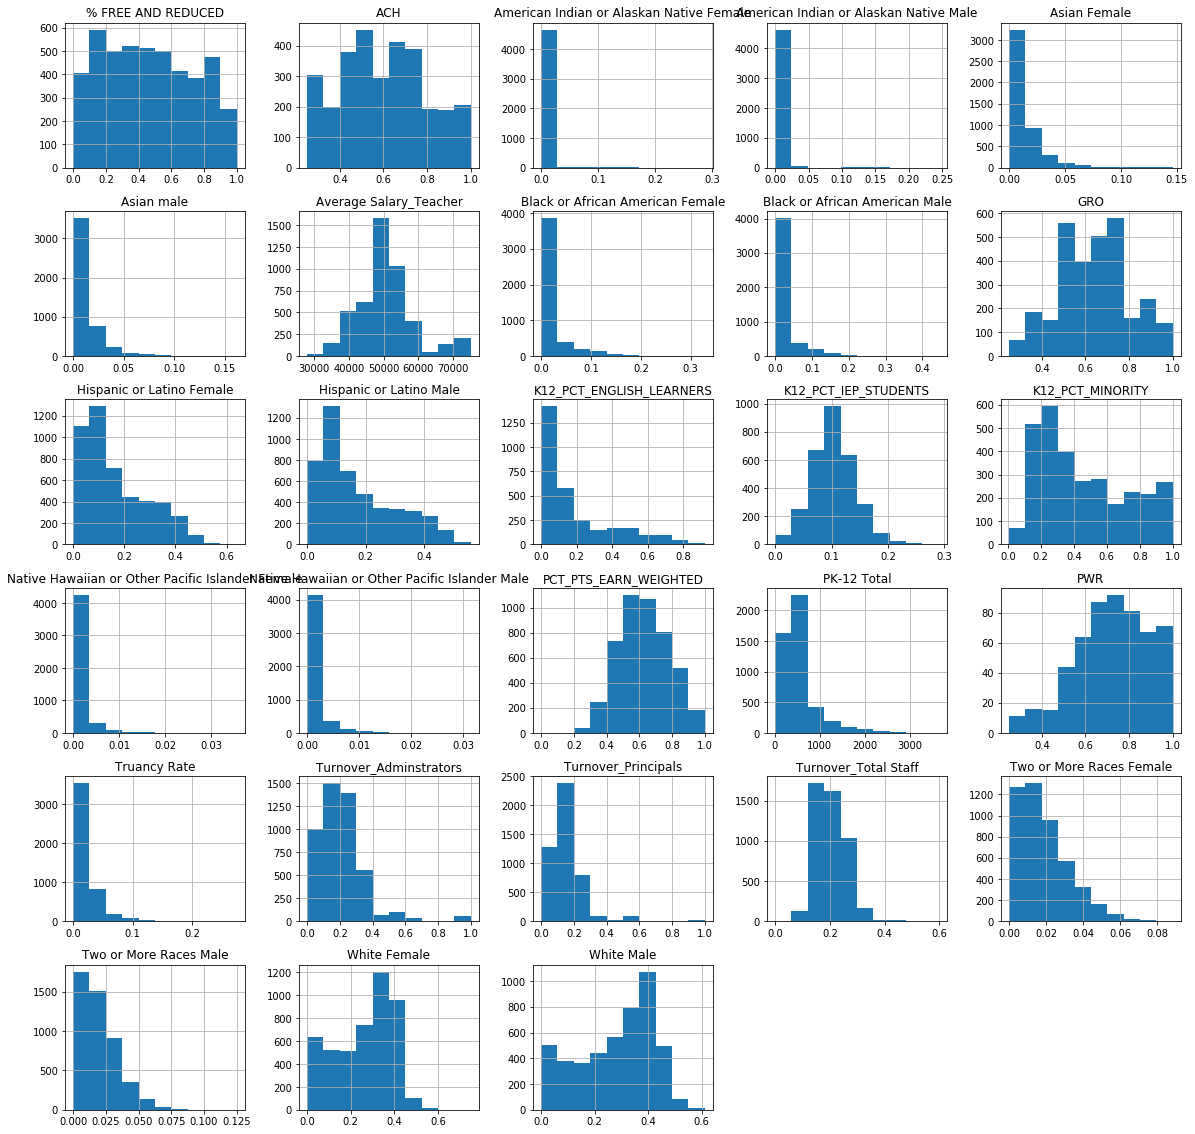

In [47]:
# Histograms
data_final.hist(figsize=[20,20])
plt.show()

In [48]:
# Skewness Calculations
skewness = pd.DataFrame(data_final.skew(),columns=["Skewness"])
skewness.sort_values("Skewness", ascending=False)

,Skewness
American Indian or Alaskan Native Female,12.910504
American Indian or Alaskan Native Male,11.844479
Native Hawaiian or Other Pacific Islander Female,3.933201
Native Hawaiian or Other Pacific Islander Male,3.914015
Black or African American Male,3.429032
Asian male,3.110487
Black or African American Female,3.087340
Truancy Rate,2.942822
District Code,2.881195
Turnover_Principals,2.822605


In [49]:
# Correlation Matrix
def color_negative_red(val):
    if abs(val) > .7:
        color = 'red'
    elif abs(val) > .4:
        color = 'blue'
    else:
        color = 'black'
    return 'color: %s' % color

data_final.corr().style.applymap(color_negative_red)

,ACH,GRO,K12_PCT_ENGLISH_LEARNERS,K12_PCT_IEP_STUDENTS,K12_PCT_MINORITY,PCT_PTS_EARN_WEIGHTED,PWR,Truancy Rate,American Indian or Alaskan Native Female,American Indian or Alaskan Native Male,Asian Female,Asian male,Black or African American Female,Black or African American Male,Hispanic or Latino Female,Hispanic or Latino Male,White Female,White Male,Native Hawaiian or Other Pacific Islander Female,Native Hawaiian or Other Pacific Islander Male,Two or More Races Female,Two or More Races Male,PK-12 Total,% FREE AND REDUCED,Average Salary_Teacher,Turnover_Adminstrators,Turnover_Principals,Turnover_Total Staff
ACH,1,0.482467,-0.548556,-0.429552,-0.661391,0.834278,0.717314,-0.495712,-0.140158,-0.152985,0.314441,0.226864,-0.237506,-0.256487,-0.652765,-0.676402,0.654399,0.642664,-0.0793475,-0.0899932,0.243103,0.239938,0.0296432,-0.748356,0.175837,-0.152337,-0.106575,-0.172968
GRO,0.482467,1,-0.0751954,-0.173059,-0.149966,0.870784,0.374406,-0.179972,-0.0982293,-0.093733,0.165343,0.146071,0.00849932,-0.0108181,-0.169185,-0.182935,0.149257,0.144733,-0.00354087,-0.00290115,0.076838,0.0985048,-0.0411367,-0.21937,0.102171,-0.0230636,-0.035649,0.028403
K12_PCT_ENGLISH_LEARNERS,-0.548556,-0.0751954,1,0.0956389,0.834568,-0.339754,-0.359545,0.412885,-0.0361279,-0.0363112,-0.00764468,0.0581607,0.289659,0.282702,0.821517,0.825964,-0.820537,-0.824164,0.0330534,0.0540754,-0.309313,-0.304449,0.00685983,0.68048,0.080744,0.218674,0.114367,0.285538
K12_PCT_IEP_STUDENTS,-0.429552,-0.173059,0.0956389,1,0.204532,-0.352365,-0.438115,0.199302,0.0586957,0.0643093,-0.211578,-0.162893,0.0774971,0.100875,0.190403,0.221712,-0.227868,-0.172831,0.0380939,0.0759088,-0.0391641,-0.0135827,-0.128871,0.382687,-0.0109756,-0.0171907,0.0615979,-0.00808785
K12_PCT_MINORITY,-0.661391,-0.149966,0.834568,0.204532,1,-0.45141,-0.479733,0.539968,0.0574895,0.0656223,-0.0296589,0.0400235,0.468973,0.461525,0.916738,0.920287,-0.981702,-0.983281,0.126647,0.146968,-0.138097,-0.139234,0.0170593,0.829094,0.0177671,0.227069,0.126839,0.305915
PCT_PTS_EARN_WEIGHTED,0.834278,0.870784,-0.339754,-0.352365,-0.45141,1,0.822427,-0.392415,-0.133374,-0.141875,0.269668,0.209484,-0.148368,-0.167798,-0.459472,-0.482355,0.453047,0.44508,-0.050095,-0.0683129,0.161492,0.166705,0.0579717,-0.560212,0.156099,-0.0817622,-0.0885593,-0.114837
PWR,0.717314,0.374406,-0.359545,-0.438115,-0.479733,0.822427,1,-0.573537,-0.177123,-0.17354,0.334362,0.22349,-0.221987,-0.247131,-0.449895,-0.487851,0.475933,0.467491,-0.0681461,-0.125516,0.16271,0.167188,0.0782771,-0.555207,0.182813,-0.121131,-0.101282,-0.166102
Truancy Rate,-0.495712,-0.179972,0.412885,0.199302,0.539968,-0.392415,-0.573537,1,0.0654996,0.0830586,-0.0702006,-0.0404969,0.31855,0.332068,0.476546,0.485523,-0.518051,-0.526973,0.0500961,0.081639,-0.130821,-0.135337,0.207473,0.465713,-0.0418281,0.121729,0.132587,0.257215
American Indian or Alaskan Native Female,-0.140158,-0.0982293,-0.0361279,0.0586957,0.0574895,-0.133374,-0.177123,0.0654996,1,0.90105,-0.0664972,-0.0661908,-0.0241767,-0.0291065,-0.0154009,-0.0106897,-0.0569091,-0.0550862,0.0441455,0.00350059,-0.0254108,-0.0113484,-0.0501899,0.0909588,-0.136179,-0.00983436,0.048299,0.0638256
American Indian or Alaskan Native Male,-0.152985,-0.093733,-0.0363112,0.0643093,0.0656223,-0.141875,-0.17354,0.0830586,0.90105,1,-0.0771044,-0.0711586,-0.0288167,-0.0276387,-0.00980724,0.00307643,-0.0706019,-0.0585975,0.0462575,0.0160195,-0.0247565,-0.000409113,-0.0555095,0.100099,-0.141477,-0.0113957,0.0505224,0.0696344


# Part III: Data Preparation

In [50]:
# Clean data

# Remove Schools with NULL values
data_final = data_final.loc[data_final["Turnover_Total Staff"].notnull()]
data_final = data_final.loc[data_final["% FREE AND REDUCED"].notnull()]

# Replace Y/N with 1/0 in order to work with python modeling packages
data_final["CHARTER_YN"] = data_final["CHARTER_YN"].replace("Y",1).replace("N",0)
data_final["ONLINE_YN"] = data_final["ONLINE_YN"].replace("Y",1).replace("N",0)

# Redundant variable
data_final.drop(["K12_PCT_MINORITY"], axis=1, inplace=True)

# Remove Alt Ed. and Closed Schools
data_final = data_final.loc[data_final["RATING_PRELIMINARY"] != "Pending AEC Framework"]
data_final = data_final.loc[data_final["RATING_PRELIMINARY"] != "School Code Closed 2018-19"]

# Convert categorical variables into binary indicators
data_final = pd.get_dummies(data_final, columns=["EMH_TYPE","District Setting"])

In [51]:
data_final["Rating (Simple)"] = ""
data_final.loc[data_final["RATING_PRELIMINARY"].str.startswith("Improvement Plan"), "Rating (Simple)"] = "Improvement Plan"
data_final.loc[data_final["RATING_PRELIMINARY"].str.startswith("Performance Plan"), "Rating (Simple)"] = "Performance Plan"
data_final.loc[data_final["RATING_PRELIMINARY"].str.startswith("Priority Improvement Plan"), "Rating (Simple)"] = "Priority Improvement Plan"
data_final.loc[data_final["RATING_PRELIMINARY"].str.startswith("Turnaround Plan"), "Rating (Simple)"] = "Turnaround Plan"
pd.crosstab(data_final["Rating (Simple)"], columns=data_final["School Year"])

School Year,2015/2016,2016/2017,2017/2018
Rating (Simple),,,
Improvement Plan,319,282,317
Performance Plan,1013,1052,1114
Priority Improvement Plan,125,105,97
Turnaround Plan,44,44,29


In [52]:
data_final.shape

(4541, 50)

In [53]:
# Prepare data modeling
train_set, test_set = train_test_split(data_final, test_size=.4, random_state=42)
x_train_set = train_set[["Truancy Rate", "American Indian or Alaskan Native Female", "American Indian or Alaskan Native Male", "Asian Female", "Asian male", "Black or African American Female", "Black or African American Male", "Hispanic or Latino Female", "Hispanic or Latino Male", "White Female", "White Male", "Native Hawaiian or Other Pacific Islander Female", "Native Hawaiian or Other Pacific Islander Male", "Two or More Races Female", "PK-12 Total", "% FREE AND REDUCED", "Average Salary_Teacher", "Turnover_Adminstrators", "Turnover_Principals", "Turnover_Total Staff", "ONLINE_YN", "CHARTER_YN", "EMH_TYPE_E", "EMH_TYPE_EM", "EMH_TYPE_EMH", "EMH_TYPE_H", "EMH_TYPE_M","District Setting_Denver Metro","District Setting_Outlying City","District Setting_Outlying Town","District Setting_Remote","District Setting_Urban-Suburban"]]
x_test_set = test_set[["Truancy Rate", "American Indian or Alaskan Native Female", "American Indian or Alaskan Native Male", "Asian Female", "Asian male", "Black or African American Female", "Black or African American Male", "Hispanic or Latino Female", "Hispanic or Latino Male", "White Female", "White Male", "Native Hawaiian or Other Pacific Islander Female", "Native Hawaiian or Other Pacific Islander Male", "Two or More Races Female", "PK-12 Total", "% FREE AND REDUCED", "Average Salary_Teacher", "Turnover_Adminstrators", "Turnover_Principals", "Turnover_Total Staff", "ONLINE_YN", "CHARTER_YN", "EMH_TYPE_E", "EMH_TYPE_EM", "EMH_TYPE_EMH", "EMH_TYPE_H", "EMH_TYPE_M","District Setting_Denver Metro","District Setting_Outlying City","District Setting_Outlying Town","District Setting_Remote","District Setting_Urban-Suburban"]]
y_train_set = train_set["PCT_PTS_EARN_WEIGHTED"]
y_test_set = test_set["PCT_PTS_EARN_WEIGHTED"]
training_data = train_set[["Truancy Rate", "American Indian or Alaskan Native Female", "American Indian or Alaskan Native Male", "Asian Female", "Asian male", "Black or African American Female", "Black or African American Male", "Hispanic or Latino Female", "Hispanic or Latino Male", "White Female", "White Male", "Native Hawaiian or Other Pacific Islander Female", "Native Hawaiian or Other Pacific Islander Male", "Two or More Races Female", "PK-12 Total", "% FREE AND REDUCED", "Average Salary_Teacher", "Turnover_Adminstrators", "Turnover_Principals", "Turnover_Total Staff", "ONLINE_YN", "CHARTER_YN", "EMH_TYPE_E", "EMH_TYPE_EM", "EMH_TYPE_EMH", "EMH_TYPE_H", "EMH_TYPE_M","District Setting_Denver Metro","District Setting_Outlying City","District Setting_Outlying Town","District Setting_Remote","District Setting_Urban-Suburban","PCT_PTS_EARN_WEIGHTED"]]

print(len(train_set), "train +", len(test_set), "test")
print("X Train: " + str(x_train_set.shape))
print("Y Train: " + str(y_train_set.shape))
print("All Train Data: " + str(training_data.shape))
print("X Test: " + str(x_test_set.shape))
print("Y Test: " + str(y_test_set.shape))

2724 train + 1817 test
X Train: (2724, 32)
Y Train: (2724,)
All Train Data: (2724, 33)
X Test: (1817, 32)
Y Test: (1817,)


# Part IV: Modeling:
1. Linear Regression
2. Decision Tree
3. Neural Network

## 1. Linear Regression

In [56]:
# Function to create linear regression and output results
def linreg(xdata_train, ydata_train, data_train, xdata_test, ydata_test):
    regr = linear_model.LinearRegression()
    regr.fit(xdata_train, ydata_train)
    y_test_pred = regr.predict(xdata_test)
    y_train_pred = regr.predict(xdata_train)

    print("Mean absolute error (Training/Testing): " + str(round(mean_absolute_error(ydata_train, y_train_pred),3)) + "/" + str(round(mean_absolute_error(ydata_test, y_test_pred),3)))
    print("Mean squared error  (Training/Testing): " + str(round(mean_squared_error(ydata_train, y_train_pred),3)) + "/" + str(round(mean_squared_error(ydata_test, y_test_pred),3)))
    print("R-squared           (Training/Testing): " + str(round(r2_score(ydata_train, y_train_pred),3)) + "/" + str(round(r2_score(ydata_test, y_test_pred),3)))
    print("")
    
    model = ols("ydata_train ~ xdata_train", data=data_train).fit()
    names = ["Intercept"] + list(xdata_train.columns)
    print(model.summary(xname=names))

    fig = plt.figure(figsize=[15,3])

    plt.subplot(1, 3, 1)
    plt.scatter(ydata_train, model.predict())
    plt.title("Actual vs. Predicted")
    diag = np.arange(ydata_train.min(), ydata_train.max(), (ydata_train.max()-ydata_train.min())/50)
    plt.scatter(diag, diag, color="red")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
   
    plt.subplot(1, 3, 2)
    plt.scatter(model.predict(), model.resid)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Predicted Rating vs Residuals")
    plt.xlabel("Predicted Rating")
    plt.ylabel("Residuals")

    plt.subplot(1, 3, 3)
    model.resid.hist()
    plt.title("Histogram of Residuals")
    plt.show()
    
    return model

Mean absolute error (Training/Testing): 0.093/0.094
Mean squared error  (Training/Testing): 0.014/0.014
R-squared           (Training/Testing): 0.392/0.368

                            OLS Regression Results                            
Dep. Variable:            ydata_train   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     54.13
Date:                Fri, 16 Nov 2018   Prob (F-statistic):          2.37e-262
Time:                        09:43:41   Log-Likelihood:                 1967.5
No. Observations:                2724   AIC:                            -3869.
Df Residuals:                    2691   BIC:                            -3674.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                     

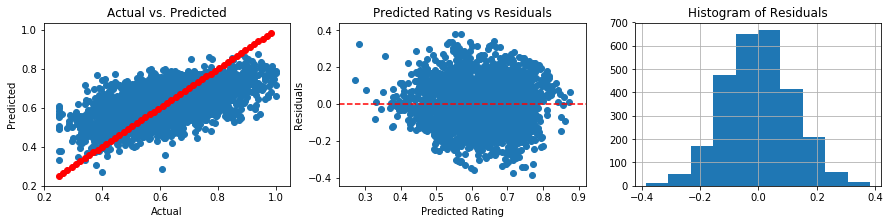

In [57]:
# First linear regression model
linreg(x_train_set, y_train_set, training_data,x_test_set, y_test_set)

In [58]:
# Functions to create a lasso optimized linear regression model
def lassoscores(alphas):
    df_scores = pd.DataFrame()
    df_scores['Scores'] = ["Training Score","Testing Score", "Mean Squared Error", "Mean Absolute Error", "Number of Features"]

    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        lasso.fit(x_train_set,y_train_set)
        column_name = 'Alpha = %f' % alpha
        train_score = lasso.score(x_train_set,y_train_set)
        test_score = lasso.score(x_test_set,y_test_set)
        coeff_used = np.sum(lasso.coef_!=0)
        mse = mean_squared_error(y_test_set, lasso.predict(x_test_set))
        mae = mean_absolute_error(y_test_set, lasso.predict(x_test_set))
        df_scores[column_name] = [train_score, test_score, mse, mae, coeff_used]
        
    return df_scores

def lassocoef(alphas):
    df = pd.DataFrame()
    df['Feature Name'] = x_train_set.columns

    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        lasso.fit(x_train_set,y_train_set)
        column_name = 'Alpha = %f' % alpha
        df[column_name] = lasso.coef_
        
    return df

In [59]:
# Compare three different lasso optimized linear regression models
lassoscores([.0001, .001, .01])

,Scores,Alpha = 0.000100,Alpha = 0.001000,Alpha = 0.010000
0,Training Score,0.379824,0.337873,0.259949
1,Testing Score,0.368521,0.332411,0.258624
2,Mean Squared Error,0.014102,0.014909,0.016557
3,Mean Absolute Error,0.094180,0.097354,0.104089
4,Number of Features,22.000000,8.000000,3.000000


In [60]:
# See variables of .001 lasso optimized linear regression models
variables = lassocoef([.001])
variables = variables.loc[variables["Alpha = 0.001000"] != 0]
variables

,Feature Name,Alpha = 0.001000
14,PK-12 Total,-2.753559e-05
15,% FREE AND REDUCED,-3.033474e-01
16,Average Salary_Teacher,9.713596e-07
20,ONLINE_YN,-3.731716e-02
21,CHARTER_YN,1.585778e-02
22,EMH_TYPE_E,1.285250e-03
26,EMH_TYPE_M,-2.511544e-02
31,District Setting_Urban-Suburban,7.160745e-03


Mean absolute error (Training/Testing): 0.098/0.097
Mean squared error  (Training/Testing): 0.015/0.015
R-squared           (Training/Testing): 0.344/0.342

                            OLS Regression Results                            
Dep. Variable:            ydata_train   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     177.9
Date:                Fri, 16 Nov 2018   Prob (F-statistic):          5.01e-242
Time:                        09:44:48   Log-Likelihood:                 1864.9
No. Observations:                2724   AIC:                            -3712.
Df Residuals:                    2715   BIC:                            -3659.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err

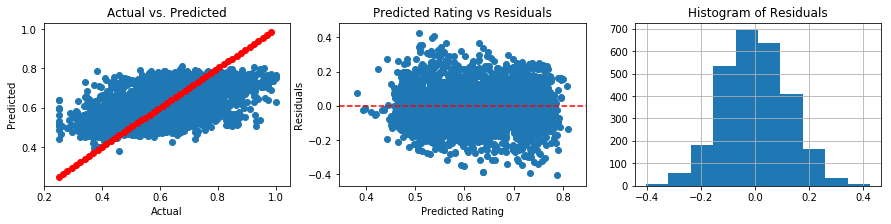

In [61]:
# Second linear regression model. Optimized using lasso.
lassovars = variables["Feature Name"].values
x_train_set_lasso = x_train_set[lassovars]
x_test_set_lasso = x_test_set[lassovars]
training_data_lasso = train_set[np.append(lassovars, "PCT_PTS_EARN_WEIGHTED")]

linreg(x_train_set_lasso, y_train_set, training_data_lasso,x_test_set_lasso, y_test_set)

Mean absolute error (Training/Testing): 0.098/0.097
Mean squared error  (Training/Testing): 0.015/0.015
R-squared           (Training/Testing): 0.344/0.342

                            OLS Regression Results                            
Dep. Variable:            ydata_train   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     203.3
Date:                Fri, 16 Nov 2018   Prob (F-statistic):          5.18e-243
Time:                        10:27:31   Log-Likelihood:                 1864.5
No. Observations:                2724   AIC:                            -3713.
Df Residuals:                    2716   BIC:                            -3666.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err

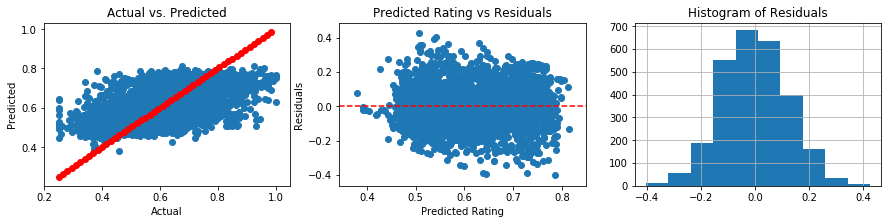

In [125]:
# Third (and final) linear regression. Optimized using lasso and removed EMH_TYPE_E from previous regression since p-value > 0.05.
lassovars = np.delete(lassovars, np.argwhere(lassovars =="EMH_TYPE_E"))
x_train_set_lasso = x_train_set[lassovars]
x_test_set_lasso = x_test_set[lassovars]
training_data_lasso = train_set[np.append(lassovars, "PCT_PTS_EARN_WEIGHTED")]

linregmodel = linreg(x_train_set_lasso, y_train_set, training_data_lasso,x_test_set_lasso, y_test_set)

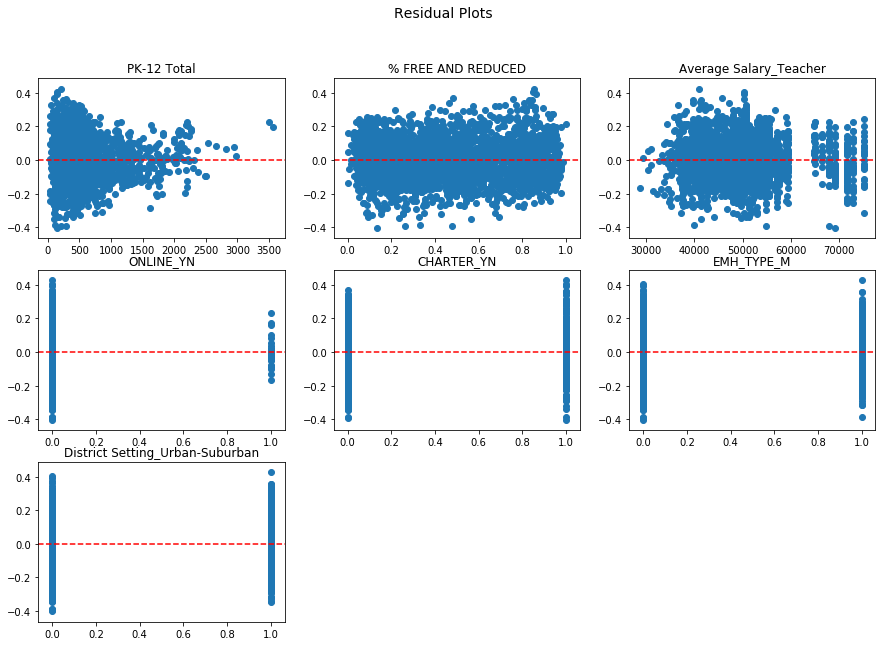

In [65]:
# Residual Plots of final linear regression model
fig = plt.figure(figsize=[15,10])
fig.suptitle("Residual Plots", fontsize=14)

x = 1
for i in lassovars:
    plt.subplot(3, 3, x)
    plt.scatter(x_train_set_lasso[i], model.resid)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(i)
    x += 1

plt.show()

In [66]:
# Impact analysis of variables in final linear regression model
coef = pd.DataFrame(model.params)
coef = coef.reset_index(drop=True)
cols = ["Intercept"] + list(x_train_set_lasso.columns)
names = pd.DataFrame(cols)
names = names.merge(coef, how="inner", left_index=True, right_index=True)
names.rename(columns={"0_x": "Variables", "0_y": "Coefficients"}, inplace=True)
var_range = pd.DataFrame(x_train_set_lasso.max() - x_train_set_lasso.min(), columns=["Range"])
names = names.merge(var_range, how="left", left_on="Variables", right_index=True)
names.loc[names.Range.isnull(), "Range"] = 1
names["Impact"] = names["Range"] * names["Coefficients"]
names["Impact (Value)"] = abs(names["Impact"])
names = names.loc[names.Variables != "Intercept"]
names.sort_values("Impact (Value)", ascending=False)

,Variables,Coefficients,Range,Impact,Impact (Value)
2,% FREE AND REDUCED,-3.182059e-01,1.00000,-0.318206,0.318206
4,ONLINE_YN,-1.369572e-01,1.00000,-0.136957,0.136957
1,PK-12 Total,-2.962997e-05,3546.00000,-0.105068,0.105068
3,Average Salary_Teacher,8.972929e-07,46387.51379,0.041623,0.041623
6,EMH_TYPE_M,-3.269275e-02,1.00000,-0.032693,0.032693
5,CHARTER_YN,2.600386e-02,1.00000,0.026004,0.026004
7,District Setting_Urban-Suburban,1.112094e-02,1.00000,0.011121,0.011121


---

Sources: 
    
https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b

https://chrisalbon.com/machine_learning/linear_regression/effect_of_alpha_on_lasso_regression/

http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html

## 2. Decision Tree

Text(0,0.5,'Mean Absolute Error')

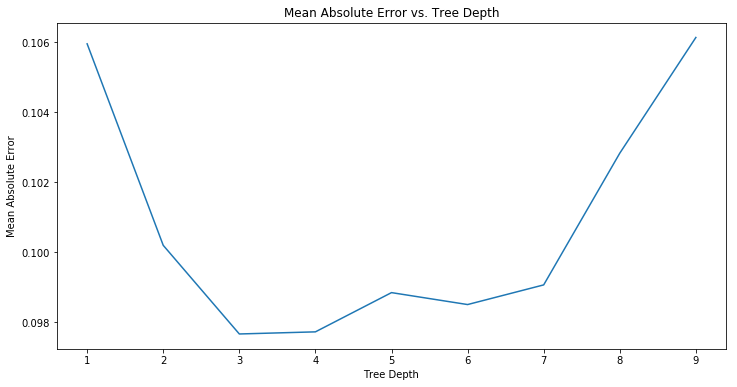

In [68]:
# Compare mean absolute error of decision trees with different number of depths
mae = []
for i in range(1, 10):
    dtree = tree.DecisionTreeRegressor(max_depth=i, random_state=42)
    dtree.fit(x_train_set, y_train_set)
    expected = y_test_set
    predicted = dtree.predict(x_test_set)
    modelscore = mean_absolute_error(expected, predicted)
    mae.append(modelscore)
    
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 10), mae)
plt.title('Mean Absolute Error vs. Tree Depth') 
plt.xlabel('Tree Depth')  
plt.ylabel('Mean Absolute Error') 

Mean absolute error (Training/Testing): 0.097/0.098
Mean square error   (Training/Testing): 0.015/0.015


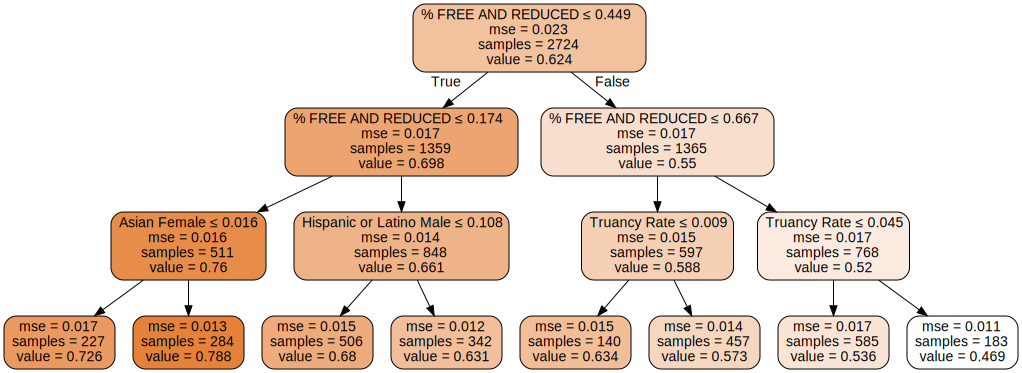

In [71]:
dtree = tree.DecisionTreeRegressor(max_depth=3, random_state=42)
dtree.fit(x_train_set, y_train_set)
y_train_pred = dtree.predict(x_train_set)
y_test_pred = dtree.predict(x_test_set)

print("Mean absolute error (Training/Testing): " + str(round(mean_absolute_error(y_train_set, y_train_pred),3)) + "/" + str(round(mean_absolute_error(y_test_set, y_test_pred),3)))
print("Mean square error   (Training/Testing): " + str(round(mean_squared_error(y_train_set, y_train_pred),3)) + "/" + str(round(mean_squared_error(y_test_set, y_test_pred),3)))

dot_data = tree.export_graphviz(dtree, out_file=None, class_names=["0","1"], feature_names = x_train_set.columns, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## 3. Neural Network

In [74]:
# Scale data to minimize net's sensitivity to feature scaling
scaler = StandardScaler()
scaler.fit(x_train_set)
x_train_scaled = scaler.transform(x_train_set)
x_test_scaled = scaler.transform(x_test_set)

In [98]:
# Function to compare mean absolute error of different sized nets
def neuronsize(size):
    mae = []
    layers = [size]

    for i in range(1, 10):   
        mlp = MLPRegressor(random_state=0, hidden_layer_sizes=layers, max_iter=1000000)
        mlp.fit(x_train_scaled, y_train_set)
        expected = y_test_set
        predicted = mlp.predict(x_test_scaled)

        modelscore = mean_absolute_error(expected, predicted)
        mae.append(modelscore)
        layers.append(size)

    plt.figure(figsize=(6, 3))  
    plt.plot(range(1, 10), mae)
    plt.title('Mean Absolute Error vs. Net Layers (w/ ' + str(size) + " neurons)") 
    plt.xlabel('Net Layers')  
    plt.ylabel('Mean Absolute Error') 

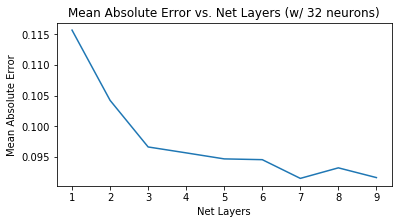

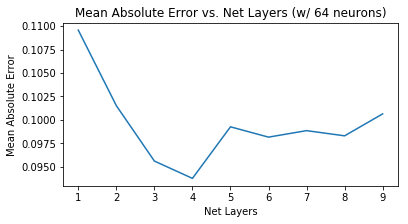

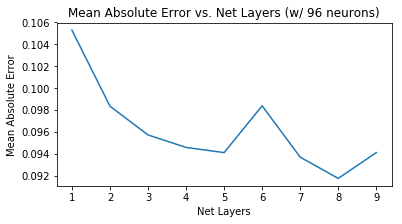

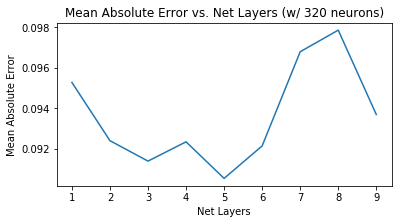

In [100]:
# Compare mean absolute error of different # of layers and neurons in each layer
neuronsize(32)
neuronsize(64)
neuronsize(96)
neuronsize(320)

Mean absolute error (Training/Testing): 0.052/0.091
Mean square error   (Training/Testing): 0.005/0.013


Text(0,0.5,'Predicted')

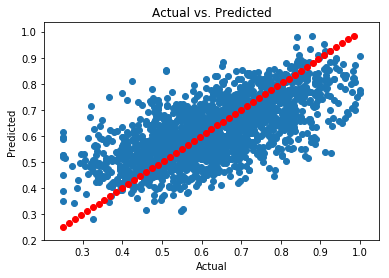

In [101]:
# Best net has 320 neurons and 5 layers
mlp = MLPRegressor(random_state=0, hidden_layer_sizes=(320,320,320,320,320), max_iter=1000000)
mlp.fit(x_train_scaled, y_train_set)
y_train_pred = mlp.predict(x_train_scaled)
y_test_pred = mlp.predict(x_test_scaled)
 
print("Mean absolute error (Training/Testing): " + str(round(mean_absolute_error(y_train_set, y_train_pred),3)) + "/" + str(round(mean_absolute_error(y_test_set, y_test_pred),3)))
print("Mean square error   (Training/Testing): " + str(round(mean_squared_error(y_train_set, y_train_pred),3)) + "/" + str(round(mean_squared_error(y_test_set, y_test_pred),3)))

plt.scatter(y_test_set, y_test_pred)
plt.title("Actual vs. Predicted")
diag = np.arange(y_test_set.min(), y_test_set.max(), (y_test_set.max()-y_test_set.min())/50)
plt.scatter(diag, diag, color="red")
plt.xlabel("Actual")
plt.ylabel("Predicted")

---

Source:

https://www.springboard.com/blog/beginners-guide-neural-network-in-python-scikit-learn-0-18/

# Part V: Evaluation

In [146]:
regr = linear_model.LinearRegression()
regr.fit(x_train_set_lasso, y_train_set)
y_test_pred = regr.predict(x_test_set_lasso)

testdata = pd.DataFrame(y_test_pred, columns=["Linear Regression"])
testdata["Actual"] = y_test_set.reset_index(drop=True)
testdata["Decision Tree"] = dtree.predict(x_test_set)
testdata["Neural Network"] = mlp.predict(x_test_scaled)

testdata.head()

,Linear Regression,Actual,Decision Tree,Neural Network
0,0.609682,0.788,0.633800,0.536564
1,0.674414,0.639,0.680374,0.626133
2,0.685963,0.670,0.680374,0.687740
3,0.539252,0.477,0.469454,0.493874
4,0.473117,0.544,0.535979,0.554986


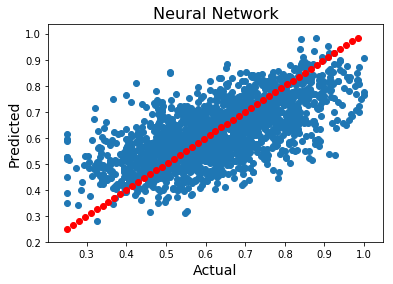

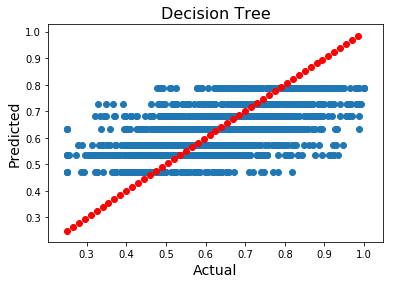

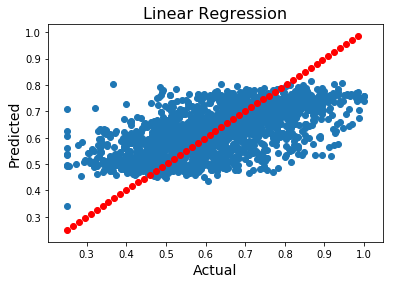

In [169]:
for i in ["Neural Network", "Decision Tree", "Linear Regression"]:
    plt.scatter(testdata["Actual"], testdata[i])
    plt.title(i, fontsize=16)
    diag = np.arange(y_test_set.min(), y_test_set.max(), (y_test_set.max()-y_test_set.min())/50)
    plt.scatter(diag, diag, color="red")
    plt.xlabel("Actual", fontsize=14)
    plt.ylabel("Predicted", fontsize=14)
    plt.show()

In [154]:
# Mean Absolute Error of all three models
print("Mean Absolute Error")
print("Neural Network:    " + str(round(mean_absolute_error(testdata["Actual"], testdata["Neural Network"]),3)))
print("Linear Regression: " + str(round(mean_absolute_error(testdata["Actual"], testdata["Linear Regression"]),3)))
print("Decision Tree:     " + str(round(mean_absolute_error(testdata["Actual"], testdata["Decision Tree"]),3)))

Mean Absolute Error
Neural Network:    0.091
Linear Regression: 0.097
Decision Tree:     0.098
